# TFM - CCC PALOS 2 - ENERGY-PRICE CURVE PREDICTION


## 1. INTRODUCTION

In this Notebook a PREDICTED ENERGY-PRICE CURVE model will be created.

The following asumptions will be considered:

+ OMIE energy-price curves from November, 2019 to October, 2020 will be considered as the baseline data information. This info comes from the csv file "OMIE_PALOS1.csv", created previously in "TFM_merged-files.ipynb" notebook.


+ As the information in OMIE file does not consider all 12 blocks for every hourly curve, it is created a new dataframe with 12 blocks for all the curves.


+ Only the following information will be considered as features of the models (X):
    * Weekday
    * Period (hour)
    * Energy offered in the block 24h (one day) before the period considered (MWh)
    * Energy offered in the block 168h (one week) before the period considered (MWh)
   NOTE: In further stages of the project, total demanded energy and fuel gas price will be included as features as well. 
   
   
+ The following information will be considered as targets of the models (y):
    * Energy offered in the block (MWh)
    * Price (€/MWh)
    
    
+ The information from the original OMIE information will be split in the following way:
    * TRAIN SET: November, 2019 - August, 2020. (Note that November will have only 3 weeks, since there are no data for the energy offered one week before the first week of the month.)
    * VALIDATION SET: September, 2020
    * TEST SET: October, 2020

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime, timedelta
from TFM_PredCurve_Tools import data_date_hour_info, convert_to_df_curve

In [2]:
#pd.reset_option('precision')
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
unit = 'PALOS2'

# FUNCTIONS TO BE STORED IN TFM_PredCurve_Tools

In [4]:
def data_date_hour_info(data, date, hour):
    return data[(data['Date']==date) & (data['Period']==hour)]

In [5]:
def convert_to_df_curve(data):
    df_curve = data[['Pot_max', 'Year', 'Month', 'Day', 'Period', 'Block', 'Price', 'Energy']]

    #Including date and week day per each day.
    #Including date
    df_curve['Date']= pd.to_datetime(df_curve[['Year', 'Month', 'Day']])

    #Including weekdays as it is an important information
    df_curve['Weekday'] = df_curve['Date'].apply(lambda x: x.weekday())
    weekDays = ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")
    df_curve['Weekday'] = df_curve['Weekday'].apply(lambda x: weekDays[x])

    #Including the total Energy for all blocks in a certain hour (to be able to plot the bid curve)
    df_curve['Energy_tot'] = df_curve.groupby(['Date','Period'])['Energy'].cumsum()

    #Sorting the dataframe by date, hour and block 
    df_curve = df_curve.sort_values(['Date','Period','Block']).reset_index(drop=True)
    
    return df_curve

In [6]:
#Searching the days with 23h and 25h within the original data period. 
#It is known that in Spain times changes from 2am to 3am every last Sunday of March and 
#from 3am to 2am every last Sunday of October

def days_25h_23h(data):

    start_year = data['Year'].min()
    end_year = data['Year'].max()

    days_23h = []
    days_25h = []

    for yx in range(start_year,end_year+1):
    
        m_min = data['Month'][data['Year']==yx].min()
        m_max = data['Month'][data['Year']==yx].max()
    
        if 10 in range(m_min,m_max+1):
            October_date = datetime(yx,10,31)
            offset_October = (October_date.weekday() - 6)%7
            last_October_sunday = October_date - timedelta(days=offset_October)
            days_25h += [last_October_sunday]
 
        if 3 in range(m_min,m_max+1):
            March_date = datetime(yx,3,31)
            offset_March = (March_date.weekday() - 6)%7
            last_March_sunday = March_date - timedelta(days=offset_March)
            days_23h += [last_March_sunday]

    return days_25h, days_23h

In [7]:
#Function to plot bid curves for a chosen dataframe, date and period (hour)

def plot_bid_curve(dataframe, date, hour):
    df_plot = dataframe[(dataframe['Date'] == date) & (dataframe['Period'] == hour)]
    return plt.plot(pd.Series(0).append(df_plot['Energy_tot']), 
                    pd.Series(df_plot['Price'].iloc[0]).append(df_plot['Price']), 
                    drawstyle='steps', 
                    label='steps (=steps-pre)')

## 2. RETRIEVING, EXPLORING AND PLOTTING OMIE DATA INFORMATION

### 2.1. RETRIEVING DATA INFORMATION

In [8]:
#df will be all data for unit PALOS1 from November 2019 to October 2020. 
#This data was previously created from OMIE web page in "TFM_merged-files.ipynb" notebook 
#and TFM_df_sel_unit_v0.ipynb.

df_unit = pd.read_csv('/home/dsc/Documents/TFM/Data/OMIE/OMIE_PALOS2_112019_102020.csv',index_col=0)

In [9]:
df_unit.head()

,Bid_Code,Num_Version,Bid_Unit,Unit_Description,Sell_Buy,Pot_max,Year,Month,Day,Period,Block,Price,Energy
0,6128192,2,PALOS2,C.C. PALOS 2,VNO,395.60,2020,1,1,1,12,180.30,395.60
1,6128192,2,PALOS2,C.C. PALOS 2,VNO,395.60,2020,1,1,2,12,180.30,395.60
2,6128192,2,PALOS2,C.C. PALOS 2,VNO,395.60,2020,1,1,3,12,180.30,395.60
3,6128192,2,PALOS2,C.C. PALOS 2,VNO,395.60,2020,1,1,4,1,1.13,50.00
4,6128192,2,PALOS2,C.C. PALOS 2,VNO,395.60,2020,1,1,4,12,180.30,345.60


In [10]:
df_unit.shape

(68034, 13)

In [11]:
df_unit.columns

Index(['Bid_Code', 'Num_Version', 'Bid_Unit', 'Unit_Description', 'Sell_Buy',
       'Pot_max', 'Year', 'Month', 'Day', 'Period', 'Block', 'Price',
       'Energy'],
      dtype='object')

In [12]:
df_unit.tail()

,Bid_Code,Num_Version,Bid_Unit,Unit_Description,Sell_Buy,Pot_max,Year,Month,Day,Period,Block,Price,Energy
68029,6126742,2,PALOS2,C.C. PALOS 2,VNO,395.60,2019,12,31,24,8,43.21,21.00
68030,6126742,2,PALOS2,C.C. PALOS 2,VNO,395.60,2019,12,31,24,9,44.30,21.00
68031,6126742,2,PALOS2,C.C. PALOS 2,VNO,395.60,2019,12,31,24,10,45.40,21.00
68032,6126742,2,PALOS2,C.C. PALOS 2,VNO,395.60,2019,12,31,24,11,46.49,21.00
68033,6126742,2,PALOS2,C.C. PALOS 2,VNO,395.60,2019,12,31,24,12,180.30,35.30


In [13]:
df_unit.describe()

,Bid_Code,Num_Version,Pot_max,Year,Month,Day,Period,Block,Price,Energy
count,"68,034.00","68,034.00","68,034.00","68,034.00","68,034.00","68,034.00","68,034.00","68,034.00","68,034.00","68,034.00"
mean,"6,311,018.51",1.75,395.60,"2,019.88",6.27,16.08,15.82,6.58,52.47,48.15
std,"140,269.64",0.85,0.00,0.32,3.38,8.84,5.19,3.63,49.21,75.45
min,"6,073,909.00",1.00,395.60,"2,019.00",1.00,1.00,1.00,1.00,1.13,0.70
25%,"6,187,944.00",1.00,395.60,"2,020.00",3.00,8.00,12.00,3.00,34.12,21.00
50%,"6,308,806.00",2.00,395.60,"2,020.00",6.00,16.00,16.00,7.00,39.92,21.00
75%,"6,432,962.00",2.00,395.60,"2,020.00",9.00,24.00,20.00,10.00,45.07,21.00
max,"6,555,574.00",5.00,395.60,"2,020.00",12.00,31.00,25.00,12.00,180.30,395.60


In [14]:
df_unit.dtypes

Bid_Code              int64
Num_Version           int64
Bid_Unit             object
Unit_Description     object
Sell_Buy             object
Pot_max             float64
Year                  int64
Month                 int64
Day                   int64
Period                int64
Block                 int64
Price               float64
Energy              float64
dtype: object

In [15]:
#Converting df_unit to a df with only the information that will be needed for ploting the bid curve, including
#date and and weekday per each day, and including the total Energy for all blocks in a certain hour,
#(to be able to plot the bid curve)

df_curve = convert_to_df_curve(df_unit)

<ipython-input-5-bb65f80c31b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve['Date']= pd.to_datetime(df_curve[['Year', 'Month', 'Day']])
<ipython-input-5-bb65f80c31b1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve['Weekday'] = df_curve['Date'].apply(lambda x: x.weekday())
<ipython-input-5-bb65f80c31b1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [16]:
df_curve.head()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,395.60,2019,11,20,1,12,180.30,395.60,2019-11-20,Wednesday,395.60
1,395.60,2019,11,20,2,12,180.30,395.60,2019-11-20,Wednesday,395.60
2,395.60,2019,11,20,3,12,180.30,395.60,2019-11-20,Wednesday,395.60
3,395.60,2019,11,20,4,12,180.30,395.60,2019-11-20,Wednesday,395.60
4,395.60,2019,11,20,5,1,1.13,50.00,2019-11-20,Wednesday,50.00


In [17]:
#Checkings to be moved to other places in the document
#Second Maximum Price (not considering the maximum of 180.3€)
df_curve[df_curve['Price']!=df_curve['Price'].max()]['Price'].max()

69.17

In [18]:
df_curve[df_curve['Price']==df_curve[df_curve['Price']!=df_curve['Price'].max()]['Price'].max()]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
26,395.60,2019,11,20,10,11,69.17,21.00,2019-11-20,Wednesday,360.30
38,395.60,2019,11,20,11,11,69.17,21.00,2019-11-20,Wednesday,360.30
50,395.60,2019,11,20,12,11,69.17,21.00,2019-11-20,Wednesday,360.30
62,395.60,2019,11,20,13,11,69.17,21.00,2019-11-20,Wednesday,360.30
74,395.60,2019,11,20,14,11,69.17,21.00,2019-11-20,Wednesday,360.30
86,395.60,2019,11,20,15,11,69.17,21.00,2019-11-20,Wednesday,360.30
98,395.60,2019,11,20,16,11,69.17,21.00,2019-11-20,Wednesday,360.30
110,395.60,2019,11,20,17,11,69.17,21.00,2019-11-20,Wednesday,360.30
122,395.60,2019,11,20,18,11,69.17,21.00,2019-11-20,Wednesday,360.30
134,395.60,2019,11,20,19,11,69.17,21.00,2019-11-20,Wednesday,360.30


In [19]:
#Second Minimum Price (not considering the maximum of 1.13€)
df_curve[df_curve['Price']!=df_curve['Price'].min()]['Price'].min()

24.52

In [20]:
#Storing the DataFrame locally
#df_curve.to_csv('/home/dsc/Repos/TFM/PALOS1_DataFrame.csv')

### 2.2. EXPLORING DATA INFORMATION

In [21]:
#Searching for NaN

if df_unit.shape[0] == df_unit.dropna().shape[0]:
    print('No NaN in df')

No NaN in df


In [22]:
data_date_hour_info(df_curve, '2020-10-31', 1)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
67844,395.60,2020,10,31,1,12,180.30,395.60,2020-10-31,Saturday,395.60


In [27]:
data_date_hour_info(df_curve,'2020-10-31',23)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
68020,395.60,2020,10,31,23,1,1.13,150.30,2020-10-31,Saturday,150.30
68021,395.60,2020,10,31,23,2,30.18,21.00,2020-10-31,Saturday,171.30
68022,395.60,2020,10,31,23,3,30.80,21.00,2020-10-31,Saturday,192.30
68023,395.60,2020,10,31,23,4,31.42,21.00,2020-10-31,Saturday,213.30
68024,395.60,2020,10,31,23,5,32.04,21.00,2020-10-31,Saturday,234.30
68025,395.60,2020,10,31,23,6,33.46,21.00,2020-10-31,Saturday,255.30
68026,395.60,2020,10,31,23,7,34.08,21.00,2020-10-31,Saturday,276.30
68027,395.60,2020,10,31,23,8,34.70,21.00,2020-10-31,Saturday,297.30
68028,395.60,2020,10,31,23,9,35.82,21.00,2020-10-31,Saturday,318.30
68029,395.60,2020,10,31,23,10,36.94,21.00,2020-10-31,Saturday,339.30


In [28]:
#Checking that hour 23 and 24 are exactly the same for one day
#A GENERAL CHECKING TO BE INCLUDED

np.array(data_date_hour_info(df_curve, '2020-10-31',24)['Price']) == np.array(data_date_hour_info(df_curve, '2020-10-31',23)['Price'])

<ipython-input-28-e7293a7ddee3>:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  np.array(data_date_hour_info(df_curve, '2020-10-31',24)['Price']) == np.array(data_date_hour_info(df_curve, '2020-10-31',23)['Price'])


False

In [29]:
np.array(data_date_hour_info(df_curve, '2020-10-31',24)['Energy']) == np.array(data_date_hour_info(df_curve, '2020-10-31',23)['Energy'])

<ipython-input-29-01a74f976ac1>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  np.array(data_date_hour_info(df_curve, '2020-10-31',24)['Energy']) == np.array(data_date_hour_info(df_curve, '2020-10-31',23)['Energy'])


False

In [30]:
data_date_hour_info(df_curve,'2020-10-25',1)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
66565,395.60,2020,10,25,1,12,180.30,395.60,2020-10-25,Sunday,395.60


In [31]:
############# CHECKING DATA FROM df_curve  #############################################

In [32]:
df_curve.shape

(68034, 11)

In [33]:
df_curve[df_curve['Block']==12].shape

(8280, 11)

In [34]:
df_curve[df_curve['Block']==12].shape[0]/24

345.0

In [35]:
#Something is wrong if the number above is not an integer

In [36]:
from datetime import datetime

first_day = datetime(df_curve['Date'].min().year,
                  df_curve['Date'].min().month,
                  df_curve['Date'].min().day)

last_day = datetime(df_curve['Date'].max().year,
                  df_curve['Date'].max().month,
                  df_curve['Date'].max().day)

In [37]:
#Checking the number of years
num_years = len(df_curve['Year'].value_counts())
num_years

2

In [38]:
#Number of missing years in the original data

num_years_real = (last_day.year - first_day.year) + 1
diff_num_years = num_years_real - num_years
diff_num_years

0

In [39]:
#Checking the number of months in the original data

num_months = len(df_curve[['Year','Month']].value_counts())
num_months

12

In [40]:
#Number of missing months in the original data

num_months_real = (last_day.month -first_day.month) + 12*(last_day.year - first_day.year) + 1
diff_num_months = num_months_real - num_months
diff_num_months

0

In [41]:
#Checking the number of days in the original data

num_days = len(df_curve['Date'].value_counts())
num_days

345

In [42]:
df_curve['Date'].min()

Timestamp('2019-11-20 00:00:00')

In [43]:
df_curve['Date'].max()

Timestamp('2020-10-31 00:00:00')

In [44]:
num_days_real = (last_day - first_day).days + 1
num_days_real

347

In [45]:
#Number of missing days in original data
diff_num_days = num_days_real - num_days
diff_num_days

2

In [46]:
#Checking the number of hours in the original data

num_hours_real = num_days_real*24 #It should be checked if within the date range there is an odd number 
                                    #of 23h-day or 25-h-day
num_hours_real


8328

In [47]:
num_hours_orig_real = num_days*24 #It should be checked if within the date range there is an odd number 
                                    #of 23h-day or 25-h-day
num_hours_orig_real

8280

In [48]:
#Checking the number of hours

num_hours = df_curve.groupby(['Date','Period'])['Block'].count().value_counts().sum()
num_hours

8280

In [49]:
#Number of missing hours from the original data
diff_num_hours = num_hours_real - num_hours
diff_num_hours

48

In [50]:
#Number of missing hours from the days in the original data
diff_num_hours_orig = num_hours_orig_real - num_hours
diff_num_hours_orig

0

In [51]:
(diff_num_hours_orig + diff_num_days*24) == diff_num_hours

True

In [52]:
#Number of hours per each block. We can see that the only block that appears in all periods is BLOCK 12.
df_curve.groupby(['Block'])['Period'].count()

Block
1     6825
2     5540
3     5534
4     5254
5     5248
6     5244
7     5233
8     5233
9     5228
10    5216
11    5199
12    8280
Name: Period, dtype: int64

In [53]:
#Variable to include the number of the block that appears always (if there are more than one the minimum is chosen).

serie_block_all = df_curve.groupby(['Block'])['Period'].count()[df_curve.groupby(['Block'])['Period'].count() == num_hours]
serie_block_all = serie_block_all.reset_index()
block_all = serie_block_all['Block'].min()
block_all

12

In [54]:
#Variable to include the maximum number of blocks

block_max = df_curve['Block'].max()
block_max

12

In [55]:
#Checking that every day has 23, 24 or 25 hours
#We know that all periods have at least the block with the number equal to block_all

df_curve_hours = df_curve[(df_curve['Block']==block_all)].groupby('Date')['Period'].count()
df_curve_hours.value_counts()

24    343
25      1
23      1
Name: Period, dtype: int64

In [56]:
#Day with less than 23 hours
df_curve_hours[(df_curve_hours != 23) & (df_curve_hours != 24) & (df_curve_hours != 25)]

Series([], Name: Period, dtype: int64)

In [57]:
#Checking data in a period of time
df_curve.loc[df_curve['Date'].isin(['2019-11-05','2019-11-17'])]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot


In [58]:
#Searching the days with 23h and 25h within the original data period. 
#It is known that in Spain times changes from 2am to 3am every last Sunday of March and 
#from 3am to 2am every last Sunday of October

days_25h, days_23h = days_25h_23h(df_curve)

In [59]:
days_25h, days_23h

([datetime.datetime(2020, 10, 25, 0, 0)],
 [datetime.datetime(2020, 3, 29, 0, 0)])

In [60]:
days_25h[0].year

2020

In [61]:
#View of some expamples of bids per hour

In [62]:
df_curve[(df_curve['Date']==days_25h[0])&(df_curve['Period'].isin([1,2,3,4,5]))]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
66565,395.60,2020,10,25,1,12,180.30,395.60,2020-10-25,Sunday,395.60
66566,395.60,2020,10,25,2,12,180.30,395.60,2020-10-25,Sunday,395.60
66567,395.60,2020,10,25,3,12,180.30,395.60,2020-10-25,Sunday,395.60
66568,395.60,2020,10,25,4,12,180.30,395.60,2020-10-25,Sunday,395.60
66569,395.60,2020,10,25,5,12,180.30,395.60,2020-10-25,Sunday,395.60


In [63]:
df_curve[(df_curve['Date']==days_23h[0])&(df_curve['Period'].isin([1,2,3,4,5]))]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
25287,395.60,2020,3,29,1,12,180.30,395.60,2020-03-29,Sunday,395.60
25288,395.60,2020,3,29,2,12,180.30,395.60,2020-03-29,Sunday,395.60
25289,395.60,2020,3,29,3,12,180.30,395.60,2020-03-29,Sunday,395.60
25290,395.60,2020,3,29,4,12,180.30,395.60,2020-03-29,Sunday,395.60
25291,395.60,2020,3,29,5,1,1.13,50.00,2020-03-29,Sunday,50.00
25292,395.60,2020,3,29,5,12,180.30,345.60,2020-03-29,Sunday,395.60


In [64]:
#View of some expamples of bids per hour

In [65]:
df_curve[(df_curve['Date']==days_25h[0])&(df_curve['Period'].isin([6,7,8]))]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
66570,395.60,2020,10,25,6,12,180.30,395.60,2020-10-25,Sunday,395.60
66571,395.60,2020,10,25,7,1,1.13,75.00,2020-10-25,Sunday,75.00
66572,395.60,2020,10,25,7,12,180.30,320.60,2020-10-25,Sunday,395.60
66573,395.60,2020,10,25,8,1,1.13,115.00,2020-10-25,Sunday,115.00
66574,395.60,2020,10,25,8,12,180.30,280.60,2020-10-25,Sunday,395.60


In [66]:
df_curve[(df_curve['Date']==days_23h[0])&(df_curve['Period'].isin([6,7,8]))]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
25293,395.60,2020,3,29,6,1,1.13,60.00,2020-03-29,Sunday,60.00
25294,395.60,2020,3,29,6,12,180.30,335.60,2020-03-29,Sunday,395.60
25295,395.60,2020,3,29,7,1,1.13,60.00,2020-03-29,Sunday,60.00
25296,395.60,2020,3,29,7,12,180.30,335.60,2020-03-29,Sunday,395.60
25297,395.60,2020,3,29,8,1,1.13,60.00,2020-03-29,Sunday,60.00
25298,395.60,2020,3,29,8,12,180.30,335.60,2020-03-29,Sunday,395.60


In [67]:
df_curve[(df_curve['Date']==days_25h[0])&(df_curve['Period'].isin([9,10]))]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
66575,395.60,2020,10,25,9,1,1.13,150.30,2020-10-25,Sunday,150.30
66576,395.60,2020,10,25,9,2,33.52,21.00,2020-10-25,Sunday,171.30
66577,395.60,2020,10,25,9,3,34.21,21.00,2020-10-25,Sunday,192.30
66578,395.60,2020,10,25,9,4,34.90,21.00,2020-10-25,Sunday,213.30
66579,395.60,2020,10,25,9,5,35.59,21.00,2020-10-25,Sunday,234.30
66580,395.60,2020,10,25,9,6,37.08,21.00,2020-10-25,Sunday,255.30
66581,395.60,2020,10,25,9,7,37.77,21.00,2020-10-25,Sunday,276.30
66582,395.60,2020,10,25,9,8,38.46,21.00,2020-10-25,Sunday,297.30
66583,395.60,2020,10,25,9,9,39.65,21.00,2020-10-25,Sunday,318.30
66584,395.60,2020,10,25,9,10,40.84,21.00,2020-10-25,Sunday,339.30


In [68]:
df_curve[(df_curve['Date']==days_23h[0])&(df_curve['Period'].isin([9,10]))]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
25299,395.60,2020,3,29,9,1,1.13,150.30,2020-03-29,Sunday,150.30
25300,395.60,2020,3,29,9,2,40.67,21.00,2020-03-29,Sunday,171.30
25301,395.60,2020,3,29,9,3,41.86,13.70,2020-03-29,Sunday,185.00
25302,395.60,2020,3,29,9,12,180.30,210.60,2020-03-29,Sunday,395.60
25303,395.60,2020,3,29,10,1,1.13,150.30,2020-03-29,Sunday,150.30
25304,395.60,2020,3,29,10,2,40.67,21.00,2020-03-29,Sunday,171.30
25305,395.60,2020,3,29,10,3,41.86,21.00,2020-03-29,Sunday,192.30
25306,395.60,2020,3,29,10,4,43.05,21.00,2020-03-29,Sunday,213.30
25307,395.60,2020,3,29,10,5,44.24,21.00,2020-03-29,Sunday,234.30
25308,395.60,2020,3,29,10,6,45.43,21.00,2020-03-29,Sunday,255.30


### 2.3. PLOTTING DATA INFORMATION

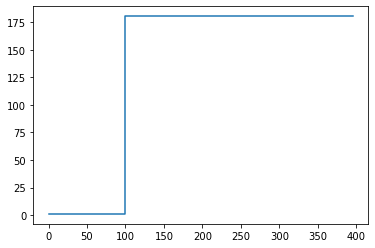

In [69]:
plot_bid_curve(df_curve, '2020-10-31', 24)

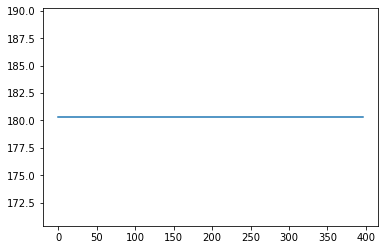

In [70]:
plot_bid_curve(df_curve,'2020-10-31', 1)

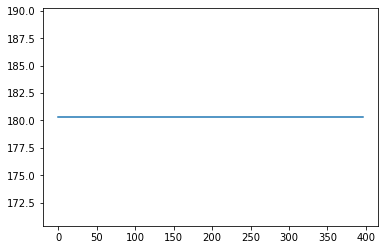

In [71]:
plot_bid_curve(df_curve,'2020-8-25', 1)

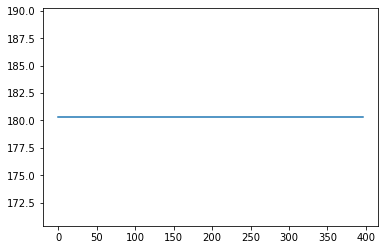

In [72]:
plot_bid_curve(df_curve,'2020-8-25',4)

In [73]:
df_curve[(df_curve['Date'] == '2019-11-9') & (df_curve['Period'] == 4)]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot


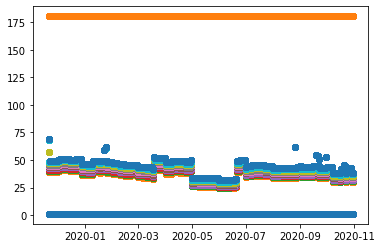

In [74]:
for block in range(1, df_curve['Block'].max()+1):
    plt.scatter(df_curve[df_curve['Block']==block]['Date'],df_curve[df_curve['Block']==block]['Price'])

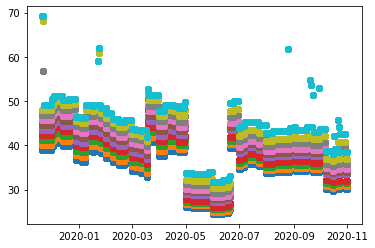

In [75]:
for block in range(2, df_curve['Block'].max()):
    plt.scatter(df_curve[df_curve['Block']==block]['Date'],df_curve[df_curve['Block']==block]['Price'])

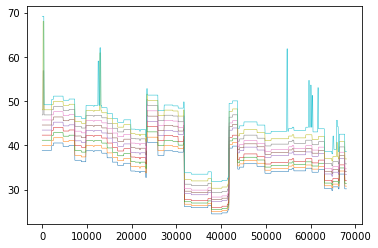

In [77]:
for block in range(2, df_curve['Block'].max()):
    df_curve[df_curve['Block']==block]['Price'].plot(linewidth=0.5)

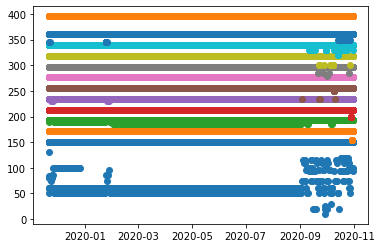

In [147]:
for block in range(1, df_curve['Block'].max()+1):
    plt.scatter(df_curve[df_curve['Block']==block]['Date'],df_curve[df_curve['Block']==block]['Energy_tot'])

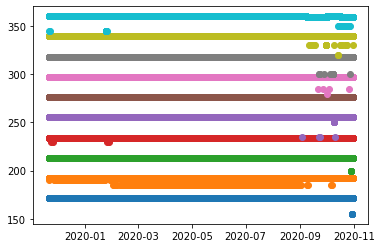

In [148]:
for block in range(2, df_curve['Block'].max()):
    plt.scatter(df_curve[df_curve['Block']==block]['Date'],df_curve[df_curve['Block']==block]['Energy_tot'])

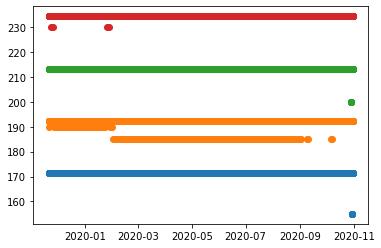

In [149]:
for block in range(2, 6):
    plt.scatter(df_curve[df_curve['Block']==block]['Date'],df_curve[df_curve['Block']==block]['Energy_tot'])

## 3. DATA WRANGLING

### 3.1. CREATING A NEW DATAFRAME CONVERTING ALL DAYS INTO 24h-DAYS

First of all a new dataframe is created considering that all days have 24h. In order to do it, it is deleted...

In [150]:
#New dataframe is created considering 24h for all days
df_curve_24h = df_curve.copy()

In [151]:
#Funtions needed for renaming periods in 23h-days and 25h-days.

def change_25h_to24h(x):
    if x >= 4:
        x -= 1
    return x

def change_23h_to24h(x):
    if x >= 2:
        x += 1
    return x

In [152]:
#Transforming 25h-day into 24h-day.

for date_25h in days_25h:
    #dataframe only with 25h-day data
    df_curve_day25h = df_curve_24h[df_curve_24h['Date']==date_25h]
    #Deleting period 3 from 25h-days.
    df_curve_day25h = df_curve_day25h.drop(df_curve_day25h.loc[df_curve_day25h['Period']==3].index)
    #Renaming periods from 4 to 25 to 3 to 24
    df_curve_day25h['Period'] = df_curve_day25h['Period'].apply(change_25h_to24h)
    df_curve_24h = df_curve_24h.drop(df_curve_24h[df_curve_24h['Date']==date_25h].index)
    df_curve_24h = pd.concat([df_curve_24h,df_curve_day25h])

In [153]:
#Transforming 23h-day into 24h-day.

for date_23h in days_23h:
    df_curve_day23h = df_curve_24h[df_curve_24h['Date']==date_23h]
    #Renaming periods from 2 to 23 to 3 to 24
    df_curve_day23h['Period'] = df_curve_day23h['Period'].apply(change_23h_to24h)
    #Copying period 1 as period 2 and renaming it
    df_curve_day23h_period1 = df_curve_day23h[(df_curve_day23h['Date']==date_23h)&(df_curve_day23h['Period']==1)]
    df_curve_day23h_period1['Period'] = df_curve_day23h_period1['Period'].apply(lambda x: x+1)
    df_curve_day23h = df_curve_day23h.append(df_curve_day23h_period1, ignore_index=True)
    df_curve_24h = df_curve_24h.drop(df_curve_24h[df_curve_24h['Date']==date_23h].index)
    df_curve_24h = pd.concat([df_curve_24h,df_curve_day23h])

<ipython-input-153-377225477582>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve_day23h['Period'] = df_curve_day23h['Period'].apply(change_23h_to24h)
<ipython-input-153-377225477582>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve_day23h_period1['Period'] = df_curve_day23h_period1['Period'].apply(lambda x: x+1)


In [154]:
df_curve_24h = df_curve_24h.sort_values(['Date','Period','Block']).reset_index(drop=True)
df_curve_24h

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,395.60,2019,11,20,1,12,180.30,395.60,2019-11-20,Wednesday,395.60
1,395.60,2019,11,20,2,12,180.30,395.60,2019-11-20,Wednesday,395.60
2,395.60,2019,11,20,3,12,180.30,395.60,2019-11-20,Wednesday,395.60
3,395.60,2019,11,20,4,12,180.30,395.60,2019-11-20,Wednesday,395.60
4,395.60,2019,11,20,5,1,1.13,50.00,2019-11-20,Wednesday,50.00
...,...,...,...,...,...,...,...,...,...,...,...
68029,395.60,2020,10,31,23,10,36.94,21.00,2020-10-31,Saturday,339.30
68030,395.60,2020,10,31,23,11,38.56,20.70,2020-10-31,Saturday,360.00
68031,395.60,2020,10,31,23,12,180.30,35.60,2020-10-31,Saturday,395.60
68032,395.60,2020,10,31,24,1,1.13,100.00,2020-10-31,Saturday,100.00


In [155]:
df_curve_24h.shape, df_curve.shape

((68034, 11), (68034, 11))


### 3.2. CREATING A NEW DATAFRAME WITH ALL BLOCKS PER EACH HOUR 

In this section a new dataframe will be created from the original one (with only 24h-days) by completing the information por every hour that does not have all blocks (12). 

It is important to point out that in the original dataframe does not have 12 blocks per each hour (or period), since not always is necessary in the biding curve. In order to use the information in the models that will be created, it is important that every hour is divided in 12 blocks. 

As the original dataframe does not have all days and hours for a given period, it is decided to create a new dataframe equal to the original one (only for dates, hours and blocks) but with all 12 blocks per each hour in the orignal data.

The new dataframe is created considering a df structure for 1 Block and then copy this new df, changing the number of the block and appending it to the original. The correct structure of the df will be created by doing it 12 times.

Then this new dataframe will be merged with the original one so NaN will be created for all the columns without blocks in the original dataframe. This NaN will be filled depending on each case.

#### 3.2.1. CREATING AN EMPTY DATAFRAME WITH THE SAME STRUCTRUE AS THE ORIGINAL WITH 24h-DAYS AND ALL BLOCKS PER EACH HOUR

In [156]:
#Checking blocks for one day
data_date_hour_info(df_curve, '2020-10-22',9)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
65981,395.60,2020,10,22,9,1,1.13,150.30,2020-10-22,Thursday,150.30
65982,395.60,2020,10,22,9,2,30.63,21.00,2020-10-22,Thursday,171.30
65983,395.60,2020,10,22,9,3,31.26,21.00,2020-10-22,Thursday,192.30
65984,395.60,2020,10,22,9,4,31.89,21.00,2020-10-22,Thursday,213.30
65985,395.60,2020,10,22,9,5,32.52,21.00,2020-10-22,Thursday,234.30
65986,395.60,2020,10,22,9,6,33.95,21.00,2020-10-22,Thursday,255.30
65987,395.60,2020,10,22,9,7,34.58,21.00,2020-10-22,Thursday,276.30
65988,395.60,2020,10,22,9,8,35.21,21.00,2020-10-22,Thursday,297.30
65989,395.60,2020,10,22,9,9,36.34,21.00,2020-10-22,Thursday,318.30
65990,395.60,2020,10,22,9,10,37.47,21.00,2020-10-22,Thursday,339.30


In [157]:
#Creating a new df with the same structure of the orinal one, without 23h and 25h-days. 
#First of all, it is choosen from the orininal df the information from the date, hours and ONE block.
#Block number "block_all" is choosen as it is the only block that it is in all the hour.

df_block_24h = df_curve_24h[['Year','Month','Day','Period','Block']][df_curve_24h['Block']==block_all].reset_index(drop=True)

#Changing the value of all Blocks to 1
df_block_24h['Block'] = 1

#Creating a new dataframe with the same structure for all Blocks
df_block_tot_24h = pd.DataFrame()

for block_24h in range(1,block_max+1):
    df_block_new_24h = df_block_24h.copy()
    df_block_new_24h['Block'] = block_24h
    df_block_tot_24h = pd.concat([df_block_tot_24h,df_block_new_24h])
    

df_block_tot_24h.reset_index(inplace=True,drop=True)

In [158]:
len(df_block_tot_24h) == df_block_24h.shape[0]*block_max

True

In [159]:
df_block_tot_24h.shape

(99360, 5)

#### 3.2.2. CREATING AN NEW DATAFRAME WITH ALL BLOCKS PER EACH HOUR (without 23h and 25h-days)

In [160]:
#Now the complete dataframe is created by merging the original df (df_curve) with the new structure dataframe 
#created (df_block_tot)

df_tot_24h = df_curve_24h.merge(df_block_tot_24h,how='outer')

#New dataframe is sorted and reseted index
df_tot_24h = df_tot_24h.sort_values(['Year','Month','Day','Period','Block']).reset_index(drop=True)

#As the structrue dataframe has more rows that the original, a lot of NaN have been created.
#These NaN must be filled.

#As Block 12 is always in the original dataframe and dataframe is sorted by 'Block', bfill is the
#right method to fill NaN since the meaning of no Block in OMIE curve is a fixed Price.
df_tot_24h['Price'].fillna(method='bfill',inplace=True)

#Pot_max is allways the same value
df_tot_24h['Pot_max'].fillna(df_tot_24h['Pot_max'].max(),inplace=True)

#For the same reason of Price, Weekday is filled with bfill method
df_tot_24h['Weekday'].fillna(method='bfill',inplace=True)

#For the same reason of Price, Datw is filled with bfill method
df_tot_24h['Date'].fillna(method='bfill',inplace=True)

#Energy NaN will be filled with 0 since allways Energy of Block 12 must be Pot_max (394.1)
df_tot_24h['Energy'].fillna(float(0),inplace=True)

#Now only Energy_tot columns have NaN
#NaN in Energy_tot can be filled by interpolation method, but first of all a value must be included
#in all cells with Block number equal to 1, since it is necessary 2 values in each Period to be able to 
#interpolate and it is the only way to fill NaN in all Periods with only one Block (12)

#Filling Energy_tot NaN for Block=1 with 50
df_tot_24h['Energy_tot'][(df_tot_24h['Block']==1) & 
                     (df_tot_24h['Energy_tot'].isnull())] = df_tot_24h['Energy_tot'][df_tot_24h['Block']==1].min()

#Now remaining NaN in Energy_tot are filled by interpolation 
df_tot_24h['Energy_tot'].interpolate(inplace=True)

<ipython-input-160-426908049f2c>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tot_24h['Energy_tot'][(df_tot_24h['Block']==1) &


In [161]:
df_tot_24h.head(15)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,395.60,2019,11,20,1,1,180.30,0.00,2019-11-20,Wednesday,10.00
1,395.60,2019,11,20,1,2,180.30,0.00,2019-11-20,Wednesday,45.05
2,395.60,2019,11,20,1,3,180.30,0.00,2019-11-20,Wednesday,80.11
3,395.60,2019,11,20,1,4,180.30,0.00,2019-11-20,Wednesday,115.16
4,395.60,2019,11,20,1,5,180.30,0.00,2019-11-20,Wednesday,150.22
5,395.60,2019,11,20,1,6,180.30,0.00,2019-11-20,Wednesday,185.27
6,395.60,2019,11,20,1,7,180.30,0.00,2019-11-20,Wednesday,220.33
7,395.60,2019,11,20,1,8,180.30,0.00,2019-11-20,Wednesday,255.38
8,395.60,2019,11,20,1,9,180.30,0.00,2019-11-20,Wednesday,290.44
9,395.60,2019,11,20,1,10,180.30,0.00,2019-11-20,Wednesday,325.49


In [162]:
#Cheching that everything is OK between original dataframe and new one

df_curve[['Block','Energy_tot']] [df_curve['Block']==1].value_counts()

Block  Energy_tot
1      150.30        5540
       60.00          847
       50.00          286
       100.00          45
       75.00           25
       95.00           16
       93.00           15
       115.00          10
       120.00           9
       20.00            9
       110.00           8
       80.00            4
       85.00            3
       84.00            2
       86.00            2
       130.00           1
       30.00            1
       25.00            1
       10.00            1
dtype: int64

In [163]:
df_tot_24h[['Block','Energy_tot']] [df_tot_24h['Block']==1].value_counts()

Block  Energy_tot
1      150.30        5540
       10.00         1456
       60.00          847
       50.00          286
       100.00          45
       75.00           25
       95.00           16
       93.00           15
       115.00          10
       120.00           9
       20.00            9
       110.00           8
       80.00            4
       85.00            3
       86.00            2
       84.00            2
       130.00           1
       30.00            1
       25.00            1
dtype: int64

In [164]:
#It is OK since the only modification is 50 that goes from 75 to 1091

In [165]:
df_tot_24h.shape

(99360, 11)

In [166]:
#df_tot_24h.to_csv('/home/dsc/Repos/TFM/df_tot_24h_PALOS1.csv')

### 3.3. CREATING AN NEW DATAFRAME WITH ALL DATES, HOURS AND BLOCKS BETWEEN THE ORIGINAL TIME PERIOD (without 23h and 25h-days)

In order to create a proper dataframe used in the models it is important to consider the data from previous bids, so a dataframe with the Energy and Price with a time lag of 24h and 168h is created. The best way to do it is to shift the columns Energy and Price 24x12 and 168x12 down, but this only works if all the dates, hours, and blocks are in the the dataframe. As it is not the case, a new dataframe should be created with NaN in the places where the dates and hours are missing in the original dataframe.

#### 3.3.1. CREATING AN EMPTY DATA STRUCTURE GIVEN A STARTING AND ENDING DATES  (without 23h & 25h-days)

In [167]:
#Moving this function to the TOOLS

from datetime import datetime, timedelta

def df_structure_24h(year_start, month_start, day_start, year_end, month_end, day_end):

    '''This function creates a empty structure of days, hours and blocks between two dates
    without 23h & 25h days'''
    
    #Adding the days of between the staring and ending days
    
    start = datetime(year_start,month_start,day_start)
    end = datetime(year_end,month_end,day_end)

    date_list = [start + timedelta(days=d) for d in range((end - start).days + 1)] 

    structure = pd.DataFrame({'Date' : date_list})
    structure['Year'] = structure['Date'].apply(lambda x: x.year)
    structure['Month'] = structure['Date'].apply(lambda x: x.month)
    structure['Day'] = structure['Date'].apply(lambda x: x.day)
    structure['Period'] = 1
    structure['Block'] = 1

    #Adding 24 hours per each day
    structure_tot = pd.DataFrame()

    for hour in range(1,25):
        structure_new = structure.copy()
        structure_new['Period'] = hour
        structure_tot = pd.concat([structure_tot,structure_new])

    structure_tot = structure_tot.reset_index(drop=True)

    #Adding maximum number of blocks per each period (hour)

    structure_block = pd.DataFrame()

    for block in range(1,block_max+1):
        structure_new = structure_tot.copy()
        structure_new['Block'] = block
        structure_block = pd.concat([structure_block,structure_new])
    
    structure_block = structure_block.sort_values(['Date','Period','Block'])
    structure_block = structure_block.reset_index(drop=True)
    return structure_block

In [168]:
struct_block_24h = df_structure_24h(df_tot_24h['Date'].min().year,
                              df_tot_24h['Date'].min().month,
                              df_tot_24h['Date'].min().day,
                              df_tot_24h['Date'].max().year,
                              df_tot_24h['Date'].max().month,
                              df_tot_24h['Date'].max().day) 

In [169]:
struct_block_24h

,Date,Year,Month,Day,Period,Block
0,2019-11-20,2019,11,20,1,1
1,2019-11-20,2019,11,20,1,2
2,2019-11-20,2019,11,20,1,3
3,2019-11-20,2019,11,20,1,4
4,2019-11-20,2019,11,20,1,5
...,...,...,...,...,...,...
99931,2020-10-31,2020,10,31,24,8
99932,2020-10-31,2020,10,31,24,9
99933,2020-10-31,2020,10,31,24,10
99934,2020-10-31,2020,10,31,24,11


#### 3.3.2. CREATING AN NEW DATAFRAME WITH ALL DATES, HOURS AND BLOCKS BETWEEN THE ORIGINAL TIME PERIOD (without 23h &25h-days)

In [170]:
df_tot_24h.shape, struct_block_24h.shape

((99360, 11), (99936, 6))

In [171]:
#Now the complete dataframe is created by merging the complete-block df (df_tot) with the new structure dataframe 
#created (structure_block)

df_tot_struct_24h = df_tot_24h.merge(struct_block_24h,how='outer')
df_tot_struct_24h = df_tot_struct_24h.sort_values(['Date','Period','Block']).reset_index(drop=True)

In [172]:
df_tot_struct_24h.head(15)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,395.60,2019,11,20,1,1,180.30,0.00,2019-11-20,Wednesday,10.00
1,395.60,2019,11,20,1,2,180.30,0.00,2019-11-20,Wednesday,45.05
2,395.60,2019,11,20,1,3,180.30,0.00,2019-11-20,Wednesday,80.11
3,395.60,2019,11,20,1,4,180.30,0.00,2019-11-20,Wednesday,115.16
4,395.60,2019,11,20,1,5,180.30,0.00,2019-11-20,Wednesday,150.22
5,395.60,2019,11,20,1,6,180.30,0.00,2019-11-20,Wednesday,185.27
6,395.60,2019,11,20,1,7,180.30,0.00,2019-11-20,Wednesday,220.33
7,395.60,2019,11,20,1,8,180.30,0.00,2019-11-20,Wednesday,255.38
8,395.60,2019,11,20,1,9,180.30,0.00,2019-11-20,Wednesday,290.44
9,395.60,2019,11,20,1,10,180.30,0.00,2019-11-20,Wednesday,325.49


In [173]:
df_tot_24h.shape, struct_block_24h.shape, df_tot_struct_24h.shape

((99360, 11), (99936, 6), (99936, 11))

In [174]:
df_tot_struct_24h[df_tot_struct_24h['Date']=='2019-11-6']

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot


In [175]:
#This df has NaN since there are days without data in the original df. These NaN will be dropped in later stages
#where the time-lagged dataframe is created

### 3.4. CREATING AN NEW DATAFRAME WITH PRICE AND ENERGY TIME-LAGGED

In [176]:
df_tot_lagT = df_tot_struct_24h.copy()

In [177]:
time_lag1 = 24 #One day in hours
time_lag2 = 24*7 #One week in hours
num_blocks = block_max #Number of blocks per each hour

df_tot_lagT['Energy_24h'] = df_tot_lagT['Energy'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Energy_168h'] = df_tot_lagT['Energy'].shift(periods=time_lag2*num_blocks)
df_tot_lagT['Price_24h'] = df_tot_lagT['Price'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Price_168h'] = df_tot_lagT['Price'].shift(periods=time_lag2*num_blocks)
df_tot_lagT['Energy_tot_24h'] = df_tot_lagT['Energy_tot'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Energy_tot_168h'] = df_tot_lagT['Energy_tot'].shift(periods=time_lag2*num_blocks)

#Just for checking purposes
df_tot_lagT['Date_24h'] = df_tot_lagT['Date'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Period_24h'] = df_tot_lagT['Period'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Block_24h'] = df_tot_lagT['Block'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Date_168h'] = df_tot_lagT['Date'].shift(periods=time_lag2*num_blocks)
df_tot_lagT['Period_168h'] = df_tot_lagT['Period'].shift(periods=time_lag2*num_blocks)
df_tot_lagT['Block_168h'] = df_tot_lagT['Block'].shift(periods=time_lag2*num_blocks)

In [178]:
df_tot_lagT.head()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,...,Price_24h,Price_168h,Energy_tot_24h,Energy_tot_168h,Date_24h,Period_24h,Block_24h,Date_168h,Period_168h,Block_168h
0,395.60,2019,11,20,1,1,180.30,0.00,2019-11-20,Wednesday,...,nan,nan,nan,nan,NaT,nan,nan,NaT,nan,nan
1,395.60,2019,11,20,1,2,180.30,0.00,2019-11-20,Wednesday,...,nan,nan,nan,nan,NaT,nan,nan,NaT,nan,nan
2,395.60,2019,11,20,1,3,180.30,0.00,2019-11-20,Wednesday,...,nan,nan,nan,nan,NaT,nan,nan,NaT,nan,nan
3,395.60,2019,11,20,1,4,180.30,0.00,2019-11-20,Wednesday,...,nan,nan,nan,nan,NaT,nan,nan,NaT,nan,nan
4,395.60,2019,11,20,1,5,180.30,0.00,2019-11-20,Wednesday,...,nan,nan,nan,nan,NaT,nan,nan,NaT,nan,nan


In [179]:
#Checking that the shift operation has been done OK

df_tot_lagT_checking = df_tot_lagT.copy()

df_tot_lagT_checking['Date_OK'] = df_tot_lagT_checking['Date'] - df_tot_lagT_checking['Date_24h']
df_tot_lagT_checking['Date_168h_OK'] = df_tot_lagT_checking['Date'] - df_tot_lagT_checking['Date_168h']
df_tot_lagT_checking['Period_OK'] = df_tot_lagT_checking['Period'] - df_tot_lagT_checking['Period_24h']
df_tot_lagT_checking['Period_168h_OK'] = df_tot_lagT_checking['Period'] - df_tot_lagT_checking['Period_168h']
df_tot_lagT_checking['Block_OK'] = df_tot_lagT_checking['Block'] - df_tot_lagT_checking['Block_24h']
df_tot_lagT_checking['Block_168h_OK'] = df_tot_lagT_checking['Block'] - df_tot_lagT_checking['Block_168h']

In [180]:
df_tot_lagT_checking[['Date_OK','Date_168h_OK','Period_OK','Period_168h_OK','Block_OK','Block_168h_OK']].describe()

,Date_OK,Date_168h_OK,Period_OK,Period_168h_OK,Block_OK,Block_168h_OK
count,99648,97920,"99,648.00","97,920.00","99,648.00","97,920.00"
mean,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00
std,0 days 00:00:00,0 days 00:00:00,0.00,0.00,0.00,0.00
min,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00
25%,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00
50%,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00
75%,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00
max,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00


In [181]:
#Everthing is OK since date date time interval is 1 day and 7 days and period, and blocks are the same for all
#of the rows

In [182]:
#Picking the correct columns
columns = ['Year', 'Month', 'Day', 'Period', 'Block', 'Date', 'Weekday',
           'Energy', 'Energy_tot','Price', 'Energy_24h', 'Energy_tot_24h', 'Price_24h', 
           'Energy_168h', 'Energy_tot_168h', 'Price_168h', 'Pot_max']

In [183]:
df_tot_lagT = df_tot_lagT[columns]

In [184]:
#Dropping all rows with NaN, since there are not enought data to build a dataframe (due to time lagging and 
#lack of data from the original dataframe

df_tot_lagT.dropna(inplace=True)
df_tot_lagT = df_tot_lagT.reset_index(drop=True)

In [185]:
#Searching for NaN

if df_tot_lagT.shape[0] == df_tot_lagT.dropna().shape[0]:
    print('No NaN in df')

No NaN in df


In [186]:
df_tot_lagT.head()

,Year,Month,Day,Period,Block,Date,Weekday,Energy,Energy_tot,Price,Energy_24h,Energy_tot_24h,Price_24h,Energy_168h,Energy_tot_168h,Price_168h,Pot_max
0,2019,11,27,1,1,2019-11-27,Wednesday,0.00,10.00,180.30,0.00,10.00,180.30,0.00,10.00,180.30,395.60
1,2019,11,27,1,2,2019-11-27,Wednesday,0.00,45.05,180.30,0.00,45.05,180.30,0.00,45.05,180.30,395.60
2,2019,11,27,1,3,2019-11-27,Wednesday,0.00,80.11,180.30,0.00,80.11,180.30,0.00,80.11,180.30,395.60
3,2019,11,27,1,4,2019-11-27,Wednesday,0.00,115.16,180.30,0.00,115.16,180.30,0.00,115.16,180.30,395.60
4,2019,11,27,1,5,2019-11-27,Wednesday,0.00,150.22,180.30,0.00,150.22,180.30,0.00,150.22,180.30,395.60


In [187]:
df_tot_lagT.shape[0]/12/24

335.0

In [188]:
(df_tot_lagT['Date'].max() - df_tot_lagT['Date'].min()).days + 1

340

### 3.5. CREATING DATAFRAMES AS MODELS' INPUT


### 3.5.1. BUILDING DATAFRAMES PER PERIOD (HOUR) - DELTA ENERGY APPROACH

In this section models' input dataframes will be created, considering that the models will be built for each period (hour). 

First of all, the following features will be considered for X:

* Weekday
* Block
* Energy 24h lagged
* Energy 168h lagged
* Price 24h lagged
* Price 168h lagged

The target variables (y) will be:

* Energy
* Price

Note that Delta Energy will be considered as Energy. It is considered that this approach will work better than considering Energy as target instead of Energy_tot.

Dataframes will be splitted in the following way:

* TRAIN SET: data set to train the models
* VALIDATION SET: data set to validate and to select the models' hyperparamenters
* TEST SET: data set to test the models

The sppliting will be done considering the following time preriods:

* TEST SET: last month of the data set --> 2020-10-01 to 2020-10-31
* VALIDATION SET: before last month of the data set --> 2020-09-01 to 2020-09-30
* TRAIN SET: rest of the dataframe

Dataframes will be splitted in the same way as it was done with the Energy_tot approach:

* TEST SET: last month of the data set --> 2020-10-01 to 2020-10-31
* VALIDATION SET: before last month of the data set --> 2020-09-01 to 2020-09-30
* TRAIN SET: rest of the dataframe

In [189]:
df_set_dE = df_tot_lagT[['Year','Month','Day','Period','Date','Weekday','Block',
                      'Energy','Price','Energy_24h','Energy_168h','Price_24h','Price_168h']]

#### TEST SET

In [190]:
df_set_dE_TEST = df_set_dE[(df_set_dE['Year'] == df_set_dE['Date'].max().year)&
               (df_set_dE['Month'] == df_set_dE['Date'].max().month)]

df_set_dE_TEST = df_set_dE_TEST.reset_index(drop=True)

df_set_dE_TEST_period = [df_set_dE_TEST[df_set_dE_TEST['Period']==hour] for hour in range(1,25)]

df_X_dE_TEST = []
y_dE_TEST = []

for df in df_set_dE_TEST_period:
    df_X_dE_TEST.append(df[['Weekday','Block','Energy_24h','Energy_168h','Price_24h','Price_168h']])
    y_dE_TEST.append(np.array(df[['Energy','Price']]))

#### VALIDATION SET

In [191]:
df_set_dE_VAL = df_set_dE[(df_set_dE['Year'] == (df_set_dE_TEST['Date'].min() - timedelta(days=1)).year)&
               (df_set_dE['Month'] == (df_set_dE_TEST['Date'].min() - timedelta(days=1)).month)]

df_set_dE_VAL = df_set_dE_VAL.reset_index(drop=True)

df_set_dE_VAL_period = [df_set_dE_VAL[df_set_dE_VAL['Period']==hour] for hour in range(1,25)]

df_X_dE_VAL = []
y_dE_VAL = []

for df in df_set_dE_VAL_period:
    df_X_dE_VAL.append(df[['Weekday','Block','Energy_24h','Energy_168h','Price_24h','Price_168h']])
    y_dE_VAL.append(np.array(df[['Energy','Price']])) #Note y_test is a np.array

#### TRAIN SET

In [192]:
df_set_dE_TRAIN_start = df_set_dE[((df_set_dE['Date'] == df_set_dE['Date'].min()) 
                                   & (df_set_dE['Period'] == 1)  
                                   & (df_set_dE['Block'] == 1))].index

df_set_dE_TRAIN_end = df_set_dE[(df_set_dE['Date'] == df_set_dE_VAL['Date'].min()- timedelta(days=1)) 
                                & (df_set_dE['Period'] == 24)  & (df_set_dE['Block'] == block_max)].index

df_set_dE_TRAIN = df_set_dE.iloc[df_set_dE_TRAIN_start[0]:df_set_dE_TRAIN_end[0]+1]

df_set_dE_num_days = (df_set_dE['Date'].max()-df_set_dE['Date'].min()).days + 1 
df_set_dE_TEST_num_days = (df_set_dE_TEST['Date'].max()-df_set_dE_TEST['Date'].min()).days + 1
df_set_dE_VAL_num_days = (df_set_dE_VAL['Date'].max()-df_set_dE_VAL['Date'].min()).days + 1
df_set_dE_TRAIN_num_days = df_set_dE_num_days - df_set_dE_TEST_num_days - df_set_dE_VAL_num_days
df_set_dE_TRAIN_num_days

df_set_dE_TRAIN_period = [df_set_dE_TRAIN[df_set_dE_TRAIN['Period']==hour] for hour in range(1,25)]

df_X_dE_TRAIN = []
y_dE_TRAIN = []

for df in df_set_dE_TRAIN_period:
    df_X_dE_TRAIN.append(df[['Weekday','Block','Energy_24h','Energy_168h','Price_24h','Price_168h']])
    y_dE_TRAIN.append(np.array(df[['Energy','Price']])) #Note y_train is a np.array

#### TRAIN + VALIDATION SET

In [193]:
df_X_dE_TRAIN_VAL = []

for hour in range(0,len(df_X_dE_TRAIN)):
    df_X_dE_TRAIN_VAL.append(pd.concat([df_X_dE_TRAIN[hour], df_X_dE_VAL[hour]],axis=0))

In [194]:
y_dE_TRAIN_VAL = []

for hour in range(0,len(df_X_dE_TRAIN)):
    y_dE_TRAIN_VAL.append(np.concatenate((y_dE_TRAIN[hour], 
                             y_dE_VAL[hour]),
                            axis=0))

### 3.5.2. NORMALIZATION AND ONE-HOT-ENCODING FOR FEATURES MODELS' INPUT - DELTA ENERGY APPROACH

In this section X_train, X_val, and X_test will be transformed to normalize the Price and Energy features (24h and 168h lagged) and Weekday, and Block (categorical variables) will be transformed using One-Hot-Encoding.

#### TRAIN SET - ENCODING

In [195]:
#One-hot encoding will be used to convert variables from categorical to binary.

from sklearn.preprocessing import OneHotEncoder

df_X_TRAIN_cat = []

for df in df_X_dE_TRAIN:
    df_X_TRAIN_cat.append(df[['Weekday','Block']])

one_encoder = OneHotEncoder(drop=None, sparse=False) #Changing 'first' with 'None'

df_X_TRAIN_cat_onehot_encoder = []

for hour in range(0,len(df_X_dE_TRAIN)):
    
    df_X_TRAIN_cat_onehot_encoder.append(one_encoder.fit(df_X_TRAIN_cat[hour]))
    
df_X_TRAIN_cat_onehot = []

for hour in range(0,len(df_X_dE_TRAIN)):
    
    df_X_TRAIN_cat_onehot.append(df_X_TRAIN_cat_onehot_encoder[hour].transform(df_X_TRAIN_cat[hour]))

In [196]:
#Normalization of Energy_tot (24h and 168h lagged) to [0,1], by dividing the entire columns with Pmax.

Energy_tot_max = df_tot_lagT['Pot_max'].max()

df_X_dE_TRAIN_energy_norm = []

for df in df_X_dE_TRAIN:
    df_X_dE_TRAIN_energy_norm.append(df[['Energy_24h', 'Energy_168h']]/Energy_tot_max)

In [197]:
#Normalization of Price (24h and 168h lagged) by stardard method (mean = 0 and std = 1)

from sklearn.preprocessing import StandardScaler

df_X_TRAIN_price = []

for df in df_X_dE_TRAIN:
    df_X_TRAIN_price.append(df[['Price_24h','Price_168h']])

std_encoder = StandardScaler()

df_X_TRAIN_price_std_encoder = []

for hour in range(0,len(df_X_dE_TRAIN)):
    
    df_X_TRAIN_price_std_encoder.append(std_encoder.fit(df_X_TRAIN_price[hour]))
    

    df_X_TRAIN_price_std = []

for hour in range(0,len(df_X_dE_TRAIN)):
    
    df_X_TRAIN_price_std.append(df_X_TRAIN_price_std_encoder[hour].transform(df_X_TRAIN_price[hour]))

In [198]:
X_dE_TRAIN = []

for hour in range(0,len(df_X_dE_TRAIN)):

    X_dE_TRAIN.append(np.concatenate((df_X_TRAIN_cat_onehot[hour], 
                             df_X_dE_TRAIN_energy_norm[hour],
                             df_X_TRAIN_price_std[hour]),
                            axis=1))

In [199]:
df_X_TRAIN_cat_onehot[0].shape, df_X_dE_TRAIN_energy_norm[0].shape, df_X_TRAIN_price_std[0].shape

((3288, 19), (3288, 2), (3288, 2))

In [200]:
len(df_X_TRAIN_cat_onehot), len(df_X_dE_TRAIN_energy_norm), len(df_X_TRAIN_price_std)

(24, 24, 24)

In [201]:
len(df_X_dE_TRAIN)

24

In [202]:
X_dE_TRAIN[0].shape

(3288, 23)

In [203]:
type(X_dE_TRAIN[0])

numpy.ndarray

#### VALIDATION SET - ENCODING --> FITTING WITH TRAIN SET

In [204]:
#One-hot encoding will be used to convert variables from categorical to binary.

df_X_VAL_cat = []
for df in df_X_dE_VAL:
    df_X_VAL_cat.append(df[['Weekday','Block']])
    
df_X_VAL_cat_onehot = []
for hour in range(0,len(df_X_dE_VAL)):
    df_X_VAL_cat_onehot.append(df_X_TRAIN_cat_onehot_encoder[hour].transform(df_X_VAL_cat[hour]))
    
#Normalization of Energy_tot (24h and 168h lagged) to [0,1], by dividing the entire columns with Pmax.
df_X_dE_VAL_energy_norm = []
for df in df_X_dE_VAL:
    df_X_dE_VAL_energy_norm.append(df[['Energy_24h', 'Energy_168h']]/Energy_tot_max)
    
#Normalization of Price (24h and 168h lagged) by stardard method (mean = 0 and std = 1)
df_X_VAL_price = []

for df in df_X_dE_VAL:
    df_X_VAL_price.append(df[['Price_24h','Price_168h']])
    
df_X_VAL_price_std = []
for hour in range(0,len(df_X_dE_VAL)):
    df_X_VAL_price_std.append(df_X_TRAIN_price_std_encoder[hour].transform(df_X_VAL_price[hour]))
    
X_dE_VAL = []
for hour in range(0,len(df_X_dE_VAL)):
    X_dE_VAL.append(np.concatenate((df_X_VAL_cat_onehot[hour], 
                             df_X_dE_VAL_energy_norm[hour],
                             df_X_VAL_price_std[hour]),
                            axis=1))

#### TEST SET - ENCODING --> FITTING WITH TRAIN_VAL SET

In [205]:
#One-hot encoding will be used to convert variables from categorical to binary.

from sklearn.preprocessing import OneHotEncoder

one_encoder = OneHotEncoder(drop=None, sparse=False) #Changing 'first' with 'None'

df_X_TEST_cat = []

for df in df_X_dE_TEST:
    df_X_TEST_cat.append(df[['Weekday','Block']])

df_X_TRAIN_VAL_cat = []

for df in df_X_dE_TRAIN_VAL:
    df_X_TRAIN_VAL_cat.append(df[['Weekday','Block']])

df_X_TRAIN_VAL_cat_onehot_encoder = []
for hour in range(0,len(df_X_dE_TRAIN_VAL)):
    df_X_TRAIN_VAL_cat_onehot_encoder.append(one_encoder.fit(df_X_TRAIN_VAL_cat[hour]))

df_X_TRAIN_VAL_cat_onehot = []
for hour in range(0,len(df_X_dE_TRAIN_VAL)):
    df_X_TRAIN_VAL_cat_onehot.append(df_X_TRAIN_VAL_cat_onehot_encoder[hour].transform(df_X_TRAIN_VAL_cat[hour]))
    
df_X_TEST_cat_onehot = []
for hour in range(0,len(df_X_dE_TEST)):
    df_X_TEST_cat_onehot.append(df_X_TRAIN_VAL_cat_onehot_encoder[hour].transform(df_X_TEST_cat[hour]))

In [206]:
#Normalization of Energy_tot (24h and 168h lagged) to [0,1], by dividing the entire columns with Pmax.
df_X_dE_TEST_energy_norm = []
for df in df_X_dE_TEST:
    df_X_dE_TEST_energy_norm.append(df[['Energy_24h', 'Energy_168h']]/Energy_tot_max)
    
df_X_dE_TRAIN_VAL_energy_norm = []
for df in df_X_dE_TRAIN_VAL:
    df_X_dE_TRAIN_VAL_energy_norm.append(df[['Energy_24h', 'Energy_168h']]/Energy_tot_max)

In [207]:
#Normalization of Price (24h and 168h lagged) by stardard method (mean = 0 and std = 1)

from sklearn.preprocessing import StandardScaler

df_X_TEST_price = []

for df in df_X_dE_TEST:
    df_X_TEST_price.append(df[['Price_24h','Price_168h']])

df_X_TRAIN_VAL_price = []

for df in df_X_dE_TRAIN_VAL:
    df_X_TRAIN_VAL_price.append(df[['Price_24h','Price_168h']])
    
std_encoder = StandardScaler()

df_X_TRAIN_VAL_price_std_encoder = []

for hour in range(0,len(df_X_dE_TRAIN_VAL)):  
    df_X_TRAIN_VAL_price_std_encoder.append(std_encoder.fit(df_X_TRAIN_VAL_price[hour]))
    
df_X_TRAIN_VAL_price_std = []
for hour in range(0,len(df_X_dE_TRAIN_VAL)):   
    df_X_TRAIN_VAL_price_std.append(df_X_TRAIN_VAL_price_std_encoder[hour].transform(df_X_TRAIN_VAL_price[hour]))
    
df_X_TEST_price_std = []
for hour in range(0,len(df_X_dE_TEST)):   
    df_X_TEST_price_std.append(df_X_TRAIN_VAL_price_std_encoder[hour].transform(df_X_TEST_price[hour]))

In [208]:
X_dE_TEST = []
for hour in range(0,len(df_X_dE_TEST)):
    X_dE_TEST.append(np.concatenate((df_X_TEST_cat_onehot[hour], 
                             df_X_dE_TEST_energy_norm[hour],
                             df_X_TEST_price_std[hour]),
                            axis=1))

In [209]:
X_dE_TRAIN_VAL = []
for hour in range(0,len(df_X_dE_TRAIN_VAL)):
    X_dE_TRAIN_VAL.append(np.concatenate((df_X_TRAIN_VAL_cat_onehot[hour], 
                             df_X_dE_TRAIN_VAL_energy_norm[hour],
                             df_X_TRAIN_VAL_price_std[hour]),
                            axis=1))

## 4. MULTI-OUTPUT REGRESSION MODELS

In this section, several multi-output regression models will be develop to predict Energy_tot and Price.

Test set will be used to adjust the models' hyperparameters and Validation test will be used to calibrate the quality of the models.

In [210]:
type(X_dE_TRAIN[0]), type(y_dE_TRAIN[0])

(numpy.ndarray, numpy.ndarray)

In [211]:
y_dE_TRAIN[0]

array([[  0. , 180.3],
       [  0. , 180.3],
       [  0. , 180.3],
       ...,
       [  0. , 180.3],
       [  0. , 180.3],
       [395.6, 180.3]])

### 4.1. MULTI-OUTPUT RANDOM FOREST REGRESSION - DELTA ENERGY APPROACH


Models are fitted with the TRAIN SET and predictions to fit the hyperparameters are checked with VALIDATION SET.
After selecting the hyperparameters, fit is done with TRAIN + VALIDATION SET and predictions with TEST SET.

In [212]:
import pickle

hours = len(X_dE_TEST)

In [213]:
# RANDOM FOREST
from sklearn.ensemble import RandomForestRegressor

reg_rf = RandomForestRegressor(n_estimators=100)

#### 4.1.1. RANDOM FOREST - BASIC APPROACH

In [214]:
reg_rf_fit_dE_TRAIN_VAL_pkl_names = []

for hour in range(0,hours):    
    model_name = '/home/dsc/Repos/TFM/Models_pkl/' + unit + '_rf_fit_dE_TRAIN_VAL_hour_' + str(hour+1) + '.pkl'
    reg_rf_fit_dE_TRAIN_VAL_pkl_names.append(model_name)
    
    #Lines commented because models have been stored already
    reg_rf_fit_dE_TRAIN_VAL = reg_rf.fit(X_dE_TRAIN_VAL[hour],y_dE_TRAIN_VAL[hour]) 
    pickle.dump(reg_rf_fit_dE_TRAIN_VAL, open(model_name, 'wb'))
    

y_dE_TEST_pred_rf = []
for hour in range(0,hours):
    loaded_model = pickle.load(open(reg_rf_fit_dE_TRAIN_VAL_pkl_names[hour], 'rb'))
    y_dE_TEST_pred_rf.append(loaded_model.predict(X_dE_TEST[hour]))

In [215]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE
mae_dE_TEST_rf = []
for hour in range(0,hours):
    mae_dE_TEST_rf.append(mean_absolute_error(y_dE_TEST[hour],y_dE_TEST_pred_rf[hour]))
mae_dE_TEST_rf

[10.207983870968722,
 7.295091397850452,
 6.893276881721417,
 9.162579971900769,
 10.886612432223368,
 13.058741888219071,
 20.599528243672697,
 28.846769363298776,
 19.360636747032544,
 7.5561229567699,
 1.6265882002003589,
 0.6735970349313262,
 0.5630606950396051,
 5.686004766767925,
 6.393429867954263,
 6.304743041517493,
 6.3601936801234,
 6.3504932012310125,
 6.350210678011872,
 9.494299626689976,
 10.965660205599448,
 10.846885517609829,
 9.13704238760761,
 18.94509623264336]

In [216]:
# RMSE from random forest

rmse_dE_TEST_rf = []
for hour in range(0,hours):
    rmse_dE_TEST_rf.append(np.sqrt(mean_squared_error(y_dE_TEST[hour],y_dE_TEST_pred_rf[hour])))
rmse_dE_TEST_rf

[40.3865318199128,
 33.26120815200734,
 32.39717984946997,
 35.64350486227529,
 38.165087301515015,
 37.88976366388465,
 49.912312160579695,
 58.27229330289317,
 44.4805696669274,
 25.202247958290304,
 10.283730983133063,
 2.6477342930344285,
 1.5046044499907323,
 24.46355116826662,
 27.12080236444937,
 26.97301898894599,
 27.023558353744523,
 27.157653969500544,
 27.265507697848744,
 35.28458993174324,
 37.18771773001494,
 37.02004630010312,
 35.0608101486479,
 51.63496053034324]

In [217]:
np.mean(mae_dE_TEST_rf), np.mean(rmse_dE_TEST_rf)

(9.731860370399383, 31.92662440198008)

#### 4.1.2. RANDOM FOREST - SELECTING HYPERPARAMENTERS

In [218]:
#Creating a fixed split for GridSearch
#Since the length of all 24 sets are equal, only is necesary to create one "test_fold"

TRAIN_len = len(X_dE_TRAIN[0])
VAL_len = len(X_dE_VAL[0])

test_fold = np.repeat([-1,0], [TRAIN_len, VAL_len])

In [219]:
from sklearn.model_selection import PredefinedSplit

ps = PredefinedSplit(test_fold)

In [220]:
#Checking the number of splits
ps.get_n_splits()

1

In [221]:
from sklearn.model_selection import GridSearchCV

reg_rf_grid = GridSearchCV(RandomForestRegressor(n_estimators=100),
                  param_grid={"max_depth":np.arange(2,11),
                              "min_samples_leaf":np.arange(10,100,15)},
                  scoring="neg_mean_absolute_error",
                  cv=ps)

In [222]:
hours = len(X_dE_TRAIN)

reg_rf_grid_fit_dE_TRAIN_VAL_pkl_names = []

for hour in range(0,hours):    
    model_name = '/home/dsc/Repos/TFM/Models_pkl/' + unit + '_rf_grid_fit_dE_TRAIN_VAL_hour_' + str(hour+1) + '.pkl'
    reg_rf_grid_fit_dE_TRAIN_VAL_pkl_names.append(model_name)
    
    #Lines commented because models have been stored already
    reg_rf_grid_fit_dE_TRAIN_VAL = reg_rf_grid.fit(X_dE_TRAIN_VAL[hour],y_dE_TRAIN_VAL[hour]) 
    pickle.dump(reg_rf_grid_fit_dE_TRAIN_VAL, open(model_name, 'wb'))
    

y_dE_TEST_pred_rf_grid = []
for hour in range(0,hours):
    loaded_model = pickle.load(open(reg_rf_grid_fit_dE_TRAIN_VAL_pkl_names[hour], 'rb'))
    y_dE_TEST_pred_rf_grid.append(loaded_model.predict(X_dE_TEST[hour]))

In [223]:
# MAE - RANDOM FOREST - GRID
mae_dE_TEST_rf_grid = []
for hour in range(0,hours):
    mae_dE_TEST_rf_grid.append(mean_absolute_error(y_dE_TEST[hour],y_dE_TEST_pred_rf_grid[hour]))
mae_dE_TEST_rf_grid

[10.032516129033233,
 7.295091397850478,
 6.87732526881825,
 9.405759850033704,
 10.81604047241269,
 14.483199065759003,
 21.737964433699563,
 28.979227767482985,
 14.341027278808413,
 4.182163585722845,
 0.8331764980297376,
 0.3533054391837949,
 0.3257094664198788,
 5.501663147689997,
 6.13190384340732,
 6.180593758490474,
 6.190266004584292,
 6.120063765941907,
 6.197505167924604,
 8.69908902140637,
 9.98630496747215,
 10.844458472627984,
 9.98109290212369,
 19.205529833068262]

In [224]:
# RMSE from random forest

rmse_dE_TEST_rf_grid = []
for hour in range(0,hours):
    rmse_dE_TEST_rf_grid.append(np.sqrt(mean_squared_error(y_dE_TEST[hour],y_dE_TEST_pred_rf_grid[hour])))
rmse_dE_TEST_rf_grid

[40.05862782813571,
 33.39043958770523,
 32.4267860559651,
 36.67615505479036,
 36.90806180117488,
 41.15942407666124,
 48.14410514289465,
 57.801761096108024,
 39.292413164440184,
 15.808534166232254,
 1.7400415014844182,
 1.060666141702018,
 0.9538113012272538,
 24.593474885662367,
 27.082128200361264,
 27.203701595895993,
 27.22775663590828,
 27.039665779898698,
 27.347648432688917,
 33.96188606312814,
 36.73938131568074,
 34.27271319853226,
 33.76550826824896,
 50.48338900725357]

In [225]:
np.mean(mae_dE_TEST_rf_grid) , np.mean(rmse_dE_TEST_rf_grid)

(9.36254073074965, 30.63075334590752)

In [226]:
np.mean(mae_dE_TEST_rf) , np.mean(rmse_dE_TEST_rf)

(9.731860370399383, 31.92662440198008)

### 4.2. MULTI-OUTPUT XG-BOOST REGRESSION - DELTA ENERGY APPROACH

Models are fitted with the TEST SET and predictions to fit the hyperparameters are checked with VALIDATION SET.

In [227]:
#XG-BOOST

from xgboost import XGBRegressor
#from sklearn.ensemble import GradientBoostingRegressor

In [228]:
#reg_XGB = GradientBoostingRegressor(max_depth=4, n_estimators=100,learning_rate=0.1)

reg_XGB = XGBRegressor(max_depth=4, n_estimators=100,learning_rate=0.1)

#### 4.2.1. XG-BOOST REGRESSION - BASIC APPROACH

##### DIRECT WRAPPER

In [229]:
from sklearn.multioutput import MultiOutputRegressor

wrapper_XGB = MultiOutputRegressor(reg_XGB)

In [230]:
   
reg_XGB_fit_dE_TRAIN_VAL_pkl_names = []

for hour in range(0,hours):    
    model_name = '/home/dsc/Repos/TFM/Models_pkl/' + unit + '_XGB_fit_dE_TRAIN_VAL_hour_' + str(hour+1) + '.pkl'
    reg_XGB_fit_dE_TRAIN_VAL_pkl_names.append(model_name)
    
    #Lines commented because models have been stored already
    wrapper_XGB_fit_dE_TRAIN_VAL = wrapper_XGB.fit(X_dE_TRAIN_VAL[hour],y_dE_TRAIN_VAL[hour]) 
    pickle.dump(wrapper_XGB_fit_dE_TRAIN_VAL, open(model_name, 'wb'))
    

y_dE_TEST_pred_XGB = []
for hour in range(0,hours):
    loaded_model = pickle.load(open(reg_XGB_fit_dE_TRAIN_VAL_pkl_names[hour], 'rb'))
    y_dE_TEST_pred_XGB.append(loaded_model.predict(X_dE_TEST[hour]))

In [231]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE - XGBOOST - TEST
mae_dE_TEST_XGB = []
for hour in range(0,hours):
    mae_dE_TEST_XGB.append(mean_absolute_error(y_dE_TEST[hour],y_dE_TEST_pred_XGB[hour]))
mae_dE_TEST_XGB

[9.651984832008043,
 7.148633255391357,
 6.773446938648664,
 8.519224330371111,
 10.455812891619182,
 11.611560942924797,
 22.990562180884744,
 30.129640446122615,
 21.22885326669101,
 8.694895917920658,
 1.5153624459107724,
 0.529684739119264,
 0.42604771553829246,
 3.392087445015549,
 3.7961045132913913,
 3.7961045132913913,
 3.7961045132913913,
 3.7961045132913913,
 3.7961045132913913,
 6.317957006071206,
 11.847473916856835,
 10.602606690263237,
 9.137013882872882,
 19.0215077363211]

In [232]:
# RMSE - XGBOOST - TEST

rmse_dE_TEST_XGB = []
for hour in range(0,hours):
    rmse_dE_TEST_XGB.append(np.sqrt(mean_squared_error(y_dE_TEST[hour],y_dE_TEST_pred_XGB[hour])))
rmse_dE_TEST_XGB

[39.6089106522382,
 33.787220107940854,
 33.04106360106596,
 35.2817981013374,
 39.06766789156065,
 38.210252965440155,
 53.837458846811856,
 59.94055696062808,
 46.84201111186123,
 26.57454523116753,
 12.60535981735535,
 2.678021385258793,
 1.1014744613707361,
 20.951847095762982,
 23.335067557654174,
 23.335067557654174,
 23.335067557654174,
 23.335067557654174,
 23.335067557654174,
 28.102431139925216,
 40.441663169332706,
 37.31546206244206,
 35.68753366728695,
 52.088539364792815]

In [233]:
np.mean(mae_dE_TEST_XGB), np.mean(rmse_dE_TEST_XGB)

(9.123953297792012, 31.409964809243764)

##### CHAIN WRAPPER

In [234]:
from sklearn.multioutput import RegressorChain

wrapper_chain_XGB = RegressorChain(reg_XGB, order=[0,1])

In [235]:
reg_chain_XGB_fit_dE_TRAIN_VAL_pkl_names = []

for hour in range(0,hours):    
    model_name = '/home/dsc/Repos/TFM/Models_pkl/' + unit + '_chain_XGB_fit_dE_TRAIN_VAL_hour_' + str(hour+1) + '.pkl'
    reg_chain_XGB_fit_dE_TRAIN_VAL_pkl_names.append(model_name)
    
    #Lines commented because models have been stored already
    chain_XGB_fit_dE_TRAIN_VAL = wrapper_chain_XGB.fit(X_dE_TRAIN_VAL[hour],y_dE_TRAIN_VAL[hour]) 
    pickle.dump(chain_XGB_fit_dE_TRAIN_VAL, open(model_name, 'wb'))
    

y_dE_TEST_pred_chain_XGB = []
for hour in range(0,hours):
    loaded_model = pickle.load(open(reg_chain_XGB_fit_dE_TRAIN_VAL_pkl_names[hour], 'rb'))
    y_dE_TEST_pred_chain_XGB.append(loaded_model.predict(X_dE_TEST[hour]))

In [236]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE - XGBOOST_chain - TEST
mae_dE_TEST_chain_XGB = []
for hour in range(0,hours):
    mae_dE_TEST_chain_XGB.append(mean_absolute_error(y_dE_TEST[hour],y_dE_TEST_pred_chain_XGB[hour]))
mae_dE_TEST_chain_XGB

[9.651984832008043,
 7.148633255391357,
 6.773446938648664,
 6.952650052339486,
 8.366324192801475,
 10.930983195824016,
 19.620724292713152,
 25.550898944565688,
 15.37433494950815,
 4.257177317379624,
 1.1453261573596674,
 0.5248647291045044,
 0.39072176544897114,
 3.3763045764353983,
 3.7844922188789627,
 3.7844922188789627,
 3.7844922188789627,
 3.7844922188789627,
 3.7844922188789627,
 4.897339515833446,
 10.096710394470282,
 9.970822859970475,
 8.158948891617918,
 18.12646660973789]

In [237]:
# RMSE - XGBOOST_chain - TEST

rmse_dE_TEST_chain_XGB = []
for hour in range(0,hours):
    rmse_dE_TEST_chain_XGB.append(np.sqrt(mean_squared_error(y_dE_TEST[hour],y_dE_TEST_pred_chain_XGB[hour])))
rmse_dE_TEST_chain_XGB

[39.6089106522382,
 33.787220107940854,
 33.04106360106596,
 32.427318050355716,
 34.52843674998823,
 37.814758818443316,
 51.76934601620669,
 58.50346085405028,
 42.98149312532499,
 19.329894556289876,
 12.34965765512731,
 2.6595044748721604,
 1.08496722365424,
 20.97689306419028,
 23.35920317819189,
 23.35920317819189,
 23.35920317819189,
 23.35920317819189,
 23.35920317819189,
 25.57647370773349,
 38.302867452981886,
 38.251913224081754,
 35.61776335996357,
 51.657431606021674]

In [238]:
np.mean(mae_dE_TEST_chain_XGB), np.mean(rmse_dE_TEST_chain_XGB)

(7.926546856898043, 30.294391257978745)

In [239]:
# Direct wrapper and Chain wrapper seems to be very similar

#### 4.2.2. XG-BOOST REGRESSION - CHAIN MULTI-OUTPUT WRAPPER APPROACH - SELECTING HYPERPARAMETERS

In [240]:
# X tiene que ser X_TEST + X_VAL y el split según X_TEST / X_VAL

In [241]:
from sklearn.model_selection import GridSearchCV

#We are using the same Predefined Split as for Random Forest

reg_XGB_grid = GridSearchCV(XGBRegressor(n_estimators=100),
                  param_grid={"max_depth":np.arange(2,10),
                             "learning_rate":np.arange(1,10)/10},
                  scoring="neg_mean_absolute_error",
                  cv=ps)

In [242]:
wrapper_chain_XGB_grid = RegressorChain(reg_XGB_grid, order=[0,1])

In [243]:
reg_chain_XGB_grid_fit_dE_TRAIN_VAL_pkl_names = []

for hour in range(0,hours):    
    model_name = '/home/dsc/Repos/TFM/Models_pkl/' + unit + '_chain_XGB_grid_fit_dE_TRAIN_VAL_hour_' + str(hour+1) + '.pkl'
    reg_chain_XGB_grid_fit_dE_TRAIN_VAL_pkl_names.append(model_name)
    
    #Lines commented because models have been stored already
    chain_XGB_grid_fit_dE_TRAIN_VAL = wrapper_chain_XGB_grid.fit(X_dE_TRAIN_VAL[hour],y_dE_TRAIN_VAL[hour]) 
    pickle.dump(chain_XGB_grid_fit_dE_TRAIN_VAL, open(model_name, 'wb'))
    

y_dE_TEST_pred_chain_XGB_grid = []
for hour in range(0,hours):
    loaded_model = pickle.load(open(reg_chain_XGB_grid_fit_dE_TRAIN_VAL_pkl_names[hour], 'rb'))
    y_dE_TEST_pred_chain_XGB_grid.append(loaded_model.predict(X_dE_TEST[hour]))

In [244]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE - XGBOOST_chain - TEST
mae_dE_TEST_chain_XGB_grid = []
for hour in range(0,hours):
    mae_dE_TEST_chain_XGB_grid.append(mean_absolute_error(y_dE_TEST[hour],y_dE_TEST_pred_chain_XGB_grid[hour]))
mae_dE_TEST_chain_XGB_grid

[9.649680662520465,
 7.146212986919183,
 6.770984565295194,
 6.9068809163971014,
 7.2204458905676425,
 11.259045035805432,
 20.607082358055536,
 24.568986683954158,
 15.219535490208736,
 6.481748364558143,
 1.3597571068425334,
 0.5733088453482562,
 0.44608406744977547,
 3.445374412651986,
 3.856005143093807,
 3.856005143093807,
 3.856005143093807,
 3.856005143093807,
 3.856005143093807,
 4.48154404210147,
 12.832654023638336,
 10.388084060309396,
 8.37943709276216,
 18.296088632092044]

In [245]:
# RMSE - XGBOOST_chain - TEST

rmse_dE_TEST_chain_XGB_grid = []
for hour in range(0,hours):
    rmse_dE_TEST_chain_XGB_grid.append(np.sqrt(mean_squared_error(y_dE_TEST[hour],y_dE_TEST_pred_chain_XGB_grid[hour])))
rmse_dE_TEST_chain_XGB_grid

[39.610131410978184,
 33.78828232510042,
 33.04209276693735,
 32.0896763572597,
 31.35482480178571,
 38.19040738969505,
 52.730416019279424,
 56.4179252665298,
 42.56360314208649,
 26.19683887237555,
 13.879676093797555,
 3.29536276665984,
 1.3557703568604145,
 20.990611361900985,
 23.371617166071594,
 23.371617166071594,
 23.371617166071594,
 23.371617166071594,
 23.371617166071594,
 24.802965012597838,
 43.64712459553295,
 38.5904354232496,
 36.365696075306005,
 52.01078367959236]

In [246]:
np.mean(mae_dE_TEST_chain_XGB_grid), np.mean(rmse_dE_TEST_chain_XGB_grid)

(8.138040039706107, 30.740862897828464)

In [247]:
np.mean(mae_dE_TEST_chain_XGB), np.mean(rmse_dE_TEST_chain_XGB)

(7.926546856898043, 30.294391257978745)

### 5. NEW METRIC CALCULATION: PERIOD CURVE AREA ERROR

In this section a curve area calculation per each period will be calculated in order to compare the original curve and the predicted one.

Area curve will have money (€) units and it will give good information about the model precision.

Four different cuve areas will be calculated:

+ Total curve area: A_tot
+ Area when Price is maximum: A_max
+ Area when Price is minimum: A_min
+ Celtral Area: A_cen = A_tot - A_max - A_min

#### NOTE: Calculating extreme areas when blocks are less than 2 is not possible, so it is checked only when using a complete dataframe (all blocks for all periods).

Extreme areas (when Price is maximum or minimum) can introduce a lot of error in the metric that cound be not very relevant for the objective of the project: since it is not very probably that extreme cases are chosen, the real effective zone for the purpose of the project is to predict well the central part of the curve.

#### TOTAL CURVE AREA METRIC

Different metrics based on curve area can be defined:

* Difference of the total curve area between y_dE and y_dE_pred (absolute and relative)
* Total absolute difference between y_dE and y_dE_pred (absolute and relative)

In [248]:
#DIFFERENCE OF THE TOTAL CURVE AREAS & TOTAL ABSOLUTE DIFFERENCE OF y_dE and y_dE_pred

def area_pred_curve_summary(y, y_pred):
    
    y_TEST_area_tot = []
    y_area_tot_diff_TEST_abs = []
    y_area_tot_diff_TEST_rel = []

    y_TEST_area = []
    y_area_diff_TEST_abs = []
    y_area_diff_TEST_rel = []
    
    hours = len(y)
    
    for hour in range(0, hours):

        y_dE_TEST_area = (y[hour][:,0]*y[hour][:,1])
        y_dE_TEST_pred_area = (y_pred[hour][:,0]*y_pred[hour][:,1])
        area_diff_TEST_abs = abs(y_dE_TEST_area - y_dE_TEST_pred_area).sum() #Total Absolute Area Differences

        y_dE_TEST_area_tot = y_dE_TEST_area.sum() #Total area for the whole set period, for each hour 
        y_dE_TEST_pred_area_tot = y_dE_TEST_pred_area.sum()
        area_tot_diff_TEST_abs = (y_dE_TEST_area_tot - y_dE_TEST_pred_area_tot) #Total Differences of Total Areas

        #Relative area difference
        area_diff_TEST_rel = (area_diff_TEST_abs / y_dE_TEST_area_tot) * 100
        area_tot_diff_TEST_rel = (area_tot_diff_TEST_abs / y_dE_TEST_area_tot) * 100

        y_area_diff_TEST_abs.append(area_diff_TEST_abs)
        y_area_diff_TEST_rel.append(area_diff_TEST_rel)

        y_TEST_area_tot.append(y_dE_TEST_area_tot)
        y_area_tot_diff_TEST_abs.append(area_tot_diff_TEST_abs)
        y_area_tot_diff_TEST_rel.append(area_tot_diff_TEST_rel)

    df_y_TEST_area_summary = pd.DataFrame({'Area_tot(€)': y_TEST_area_tot,
                  'Area_diff_abs(€)': y_area_diff_TEST_abs, 
                  'Area_diff_rel(%)': y_area_diff_TEST_rel,
                  'Area_tot_diff_abs(€)': y_area_tot_diff_TEST_abs, 
                  'Area_tot_diff_rel(%)': y_area_tot_diff_TEST_rel})
    
    return df_y_TEST_area_summary

In [249]:
df_y_TEST_area_pred_rf_grid_summary = area_pred_curve_summary(y_dE_TEST, y_dE_TEST_pred_rf_grid)
df_y_TEST_area_pred_rf_grid_summary

,Area_tot(€),Area_diff_abs(€),Area_diff_rel(%),Area_tot_diff_abs(€),Area_tot_diff_rel(%)
0,"2,006,543.54","288,506.67",14.38,"-41,958.71",-2.09
1,"2,049,523.17","202,740.56",9.89,"-33,215.89",-1.62
2,"2,058,481.67","187,962.93",9.13,"-35,669.65",-1.73
3,"2,058,481.67","207,668.89",10.09,"-11,437.94",-0.56
4,"2,031,606.17","251,166.69",12.36,"-19,658.87",-0.97
5,"1,867,949.96","430,386.17",23.04,"88,555.87",4.74
6,"1,485,023.58","646,796.83",43.55,"-29,497.48",-1.99
7,"1,005,290.29","678,351.91",67.48,"56,581.85",5.63
8,"642,835.27","295,525.04",45.97,"-39,853.44",-6.20
9,"479,022.95","98,046.32",20.47,"-1,483.45",-0.31


In [250]:
# It can be seen that the bidding area for hours from 10 to 24 is the same, so the bid is the same 
# for 15 hours per day --> Possibility of reducing models???

In [251]:
df_y_TEST_area_pred_rf_summary = area_pred_curve_summary(y_dE_TEST, y_dE_TEST_pred_rf)
df_y_TEST_area_pred_rf_summary

,Area_tot(€),Area_diff_abs(€),Area_diff_rel(%),Area_tot_diff_abs(€),Area_tot_diff_rel(%)
0,"2,006,543.54","312,044.48",15.55,"-52,657.71",-2.62
1,"2,049,523.17","202,740.56",9.89,"-50,334.29",-2.46
2,"2,058,481.67","190,102.73",9.24,"-47,795.19",-2.32
3,"2,058,481.67","229,552.68",11.15,"-41,178.67",-2.00
4,"2,031,606.17","248,145.09",12.21,"-7,943.72",-0.39
5,"1,867,949.96","411,618.01",22.04,"-31,501.60",-1.69
6,"1,485,023.58","646,947.40",43.56,"-7,041.29",-0.47
7,"1,005,290.29","681,377.97",67.78,"-245,887.93",-24.46
8,"642,835.27","315,050.82",49.01,"-139,468.72",-21.70
9,"479,022.95","204,866.41",42.77,"-123,815.79",-25.85


In [252]:
#INCLUDE HERE MORE INFORMATION FROM THE TABLE & GRAPHICS

In [253]:
#List of df with the comparison of real data and prediction for every hour.
#Returning a complete df for all predictions

def df_pred_summary(y, y_pred):

    df_pred_summary = []
    
    hours = len(y)

    for hour in range(0, hours):

        df_pred = pd.DataFrame(np.concatenate([y[hour],y_pred[hour]],axis=1), 
                                       columns= ['dE','Price','dE_pred','Price_pred'])
        df_pred['dE_diff'] = df_pred['dE'] - df_pred['dE_pred']
        df_pred['Price_diff'] = df_pred['Price'] - df_pred['Price_pred']
        df_pred['Area'] = df_pred['dE'] * df_pred['Price']
        df_pred['Area_pred'] = df_pred['dE_pred'] * df_pred['Price_pred']
        df_pred['Area_diff'] = df_pred['Area'] - df_pred['Area_pred']
        df_pred['Area_diff_rel(%)'] = df_pred['Area_diff']/df_pred['Area']*100
        df_pred['Period'] = hour + 1
        
        df_pred_summary.append(df_pred)

    # Creating a df with all the comparisons (to be able to retreive info easily)

    df_y_pred_summary = pd.DataFrame()

    for hour in range(0, len(df_pred_summary)):
        df_y_pred_summary = pd.concat([df_y_pred_summary,df_pred_summary[hour]])
        
    df_y_pred_summary.fillna(0,inplace=True)
    df_y_pred_summary.reset_index(drop=True,inplace=True)
        
    return df_y_pred_summary

In [254]:
df_TEST_pred_rf_summary  = df_pred_summary(y_dE_TEST, y_dE_TEST_pred_rf)

In [255]:
df_TEST_pred_rf_summary[(df_TEST_pred_rf_summary['Period']==10) & (df_TEST_pred_rf_summary['dE_diff']<-2)]

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
3356,0.00,180.30,5.11,152.78,-5.11,27.52,0.00,780.69,-780.69,-inf,10
3357,0.00,180.30,5.74,148.72,-5.74,31.58,0.00,853.20,-853.20,-inf,10
3358,0.00,180.30,6.16,146.07,-6.16,34.23,0.00,899.36,-899.36,-inf,10
3359,115.60,180.30,168.46,178.51,-52.86,1.79,"20,842.68","30,070.62","-9,227.94",-44.27,10
3371,35.30,180.30,55.59,180.30,-20.29,0.00,"6,364.59","10,022.52","-3,657.93",-57.47,10
3419,35.30,180.30,218.49,180.30,-183.19,0.00,"6,364.59","39,393.03","-33,028.44",-518.94,10
3431,35.30,180.30,170.68,180.30,-135.38,0.00,"6,364.59","30,774.26","-24,409.67",-383.52,10
3443,35.30,180.30,127.21,178.51,-91.91,1.79,"6,364.59","22,708.93","-16,344.34",-256.80,10
3473,0.70,33.54,21.00,33.68,-20.30,-0.14,23.48,707.33,-683.86,"-2,912.75",10
3474,0.00,180.30,21.00,34.08,-21.00,146.22,0.00,715.71,-715.71,-inf,10


In [256]:
df_TEST_pred_rf_summary.describe()

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
count,"8,928.00","8,928.00","8,928.00","8,928.00","8,928.00","8,928.00","8,928.00","8,928.00","8,928.00","8,928.00","8,928.00"
mean,32.97,87.91,32.81,91.78,0.16,-3.87,"2,593.60","2,739.88",-146.28,-inf,12.50
std,65.25,72.39,64.23,70.92,27.43,40.34,"10,725.72","10,627.88","4,402.73",nan,6.92
min,0.00,1.13,0.00,1.13,-360.10,-179.17,0.00,0.00,"-64,926.03",-inf,1.00
25%,0.00,34.08,0.00,35.30,0.00,-0.53,0.00,0.00,-32.84,-3.57,6.75
50%,21.00,38.46,21.00,41.05,0.00,0.00,693.84,727.39,0.00,0.00,12.50
75%,21.00,180.30,21.00,180.30,0.00,0.00,778.68,822.37,0.00,0.00,18.25
max,395.60,180.30,395.60,180.30,360.29,179.17,"71,326.68","71,326.68","64,960.95",100.00,24.00


In [257]:
df_TEST_pred_rf_summary['Area_diff'].mean()

-146.28107977644632

In [258]:
Area_pred_mean_error_TEST = df_TEST_pred_rf_summary['Area_diff'].mean()
Area_pred_mean_error_TEST_rel = df_TEST_pred_rf_summary['Area_diff'].mean() / df_TEST_pred_rf_summary['Area'].mean() * 100
Area_pred_mean_error_TEST, Area_pred_mean_error_TEST_rel

(-146.28107977644632, -5.640085581531988)

In [259]:
#MAE for Area and Area_pred

mae_area_pred_TEST = mean_absolute_error(df_TEST_pred_rf_summary['Area'],df_TEST_pred_rf_summary['Area_pred'])
mae_area_pred_TEST

657.7194230368902

In [260]:
#RMSE for Area and Area_pred

rmse_area_pred_TEST = (np.sqrt(mean_squared_error(df_TEST_pred_rf_summary['Area'],df_TEST_pred_rf_summary['Area_pred'])))
rmse_area_pred_TEST

4404.9136333943525

In [261]:
#Looking for min and max values in the df

df_TEST_pred_rf_summary[(df_TEST_pred_rf_summary['Price_diff'] < -7) |
                      (df_TEST_pred_rf_summary['Price_diff'] > 5)]

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
84,150.30,1.13,0.00,180.30,150.30,-179.17,169.84,0.00,169.84,100.00,1
85,21.00,30.25,0.00,180.30,21.00,-150.05,635.25,0.00,635.25,100.00,1
86,21.00,30.87,0.00,180.30,21.00,-149.43,648.27,0.00,648.27,100.00,1
87,21.00,31.49,0.00,180.30,21.00,-148.81,661.29,0.00,661.29,100.00,1
88,21.00,32.11,0.00,180.30,21.00,-148.19,674.31,0.00,674.31,100.00,1
...,...,...,...,...,...,...,...,...,...,...,...
8910,0.00,180.30,21.00,38.73,-21.00,141.57,0.00,813.23,-813.23,-inf,24
8911,0.00,180.30,21.00,38.94,-21.00,141.36,0.00,817.84,-817.84,-inf,24
8912,0.00,180.30,21.00,37.44,-21.00,142.86,0.00,786.33,-786.33,-inf,24
8913,0.00,180.30,21.00,45.59,-21.00,134.71,0.00,957.38,-957.38,-inf,24


In [262]:
df_TEST_pred_rf_summary[(df_TEST_pred_rf_summary['Price_diff'] < -7) |
                      (df_TEST_pred_rf_summary['Price_diff'] > 5)]

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
84,150.30,1.13,0.00,180.30,150.30,-179.17,169.84,0.00,169.84,100.00,1
85,21.00,30.25,0.00,180.30,21.00,-150.05,635.25,0.00,635.25,100.00,1
86,21.00,30.87,0.00,180.30,21.00,-149.43,648.27,0.00,648.27,100.00,1
87,21.00,31.49,0.00,180.30,21.00,-148.81,661.29,0.00,661.29,100.00,1
88,21.00,32.11,0.00,180.30,21.00,-148.19,674.31,0.00,674.31,100.00,1
...,...,...,...,...,...,...,...,...,...,...,...
8910,0.00,180.30,21.00,38.73,-21.00,141.57,0.00,813.23,-813.23,-inf,24
8911,0.00,180.30,21.00,38.94,-21.00,141.36,0.00,817.84,-817.84,-inf,24
8912,0.00,180.30,21.00,37.44,-21.00,142.86,0.00,786.33,-786.33,-inf,24
8913,0.00,180.30,21.00,45.59,-21.00,134.71,0.00,957.38,-957.38,-inf,24


In [263]:
#Looking for maximum price difference
#It does not seems very important, since the error comes in a place where unit will not be operating

df_TEST_pred_rf_summary [df_TEST_pred_rf_summary['Area_diff_rel(%)']== float('-inf')]

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
1188,0.00,180.30,1.22,175.92,-1.22,4.38,0.00,214.88,-214.88,-inf,4
1218,0.00,180.30,29.34,75.15,-29.34,105.15,0.00,"2,205.16","-2,205.16",-inf,4
1219,0.00,180.30,29.34,75.15,-29.34,105.15,0.00,"2,205.16","-2,205.16",-inf,4
1220,0.00,180.30,29.34,75.15,-29.34,105.15,0.00,"2,205.16","-2,205.16",-inf,4
1224,0.00,180.30,50.00,1.13,-50.00,179.17,0.00,56.50,-56.50,-inf,4
...,...,...,...,...,...,...,...,...,...,...,...
8910,0.00,180.30,21.00,38.73,-21.00,141.57,0.00,813.23,-813.23,-inf,24
8911,0.00,180.30,21.00,38.94,-21.00,141.36,0.00,817.84,-817.84,-inf,24
8912,0.00,180.30,21.00,37.44,-21.00,142.86,0.00,786.33,-786.33,-inf,24
8913,0.00,180.30,21.00,45.59,-21.00,134.71,0.00,957.38,-957.38,-inf,24


In [264]:
#Looking for minimmum price difference

df_TEST_pred_rf_summary[(df_TEST_pred_rf_summary['Period'] == 11) &
                      (abs(df_TEST_pred_rf_summary['Price_diff']) >= 1)]

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
3730,20.70,43.75,16.90,85.30,3.80,-41.55,905.62,"1,441.38",-535.75,-59.16,11
3740,21.00,40.83,21.00,39.36,0.00,1.47,857.43,826.48,30.95,3.61,11
3741,21.00,42.04,21.00,39.64,0.00,2.40,882.84,832.52,50.32,5.70,11
3742,21.00,43.75,20.90,40.10,0.10,3.65,918.75,838.14,80.61,8.77,11
3753,21.00,42.04,21.00,40.57,0.00,1.47,882.84,852.00,30.84,3.49,11
...,...,...,...,...,...,...,...,...,...,...,...
4073,21.00,33.46,21.00,36.74,0.00,-3.28,702.66,771.54,-68.88,-9.80,11
4074,21.00,34.08,21.00,38.47,0.00,-4.39,715.68,807.94,-92.26,-12.89,11
4075,21.00,34.70,21.00,38.23,0.00,-3.53,728.70,802.92,-74.22,-10.18,11
4077,21.00,36.94,21.00,42.59,0.00,-5.65,775.74,894.37,-118.63,-15.29,11


#### CURVE AREA METRIC WHEN MAXIMUM PRICE IS NOT CONSIDERED --> NO SÉ SI ES MEJOR BORRAR ESTO

When Price is the maximum (180.3€) the unit is not going to be operated, son these areas should not be cosidered to evaluate the quality of the model.

In [265]:
#NO TENGO CLARO QUE ESTA MÉTRICA TENGA MUCHO SENTIDO

In [266]:
def df_pred_summary_noPmax(df):
    
    df_noPmax = df[df['Price'] != df['Price'].max()]
    
    return df_noPmax

In [267]:
#Looking for maximum price

df_TEST_pred_rf_summary_Pmax = df_TEST_pred_rf_summary[df_TEST_pred_rf_summary['Price'] == df_TEST_pred_rf_summary['Price'].max()]

In [268]:
df_TEST_pred_rf_summary_Pmax[df_TEST_pred_rf_summary_Pmax['dE_diff']>1]

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
119,395.60,180.30,288.79,180.30,106.81,0.00,"71,326.68","52,068.48","19,258.20",27.00,1
179,395.60,180.30,150.33,180.30,245.27,0.00,"71,326.68","27,104.14","44,222.54",62.00,1
191,395.60,180.30,257.14,180.30,138.46,0.00,"71,326.68","46,362.34","24,964.34",35.00,1
251,395.60,180.30,257.14,180.30,138.46,0.00,"71,326.68","46,362.34","24,964.34",35.00,1
491,395.60,180.30,269.01,180.30,126.59,0.00,"71,326.68","48,502.14","22,824.54",32.00,2
...,...,...,...,...,...,...,...,...,...,...,...
8195,395.60,180.30,353.95,180.30,41.65,0.00,"71,326.68","63,817.18","7,509.50",10.53,23
8351,395.60,180.30,45.69,180.30,349.91,0.00,"71,326.68","8,238.55","63,088.13",88.45,23
8723,395.60,180.30,41.60,180.30,354.00,0.00,"71,326.68","7,501.30","63,825.38",89.48,24
8759,275.60,180.30,35.30,180.30,240.30,0.00,"49,690.68","6,364.59","43,326.09",87.19,24


In [269]:
#df without Pmax Areas

df_TEST_pred_rf_summary_noPmax = df_pred_summary_noPmax(df_TEST_pred_rf_summary)
df_TEST_pred_rf_summary_noPmax.head()

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
84,150.30,1.13,0.00,180.30,150.30,-179.17,169.84,0.00,169.84,100.00,1
85,21.00,30.25,0.00,180.30,21.00,-150.05,635.25,0.00,635.25,100.00,1
86,21.00,30.87,0.00,180.30,21.00,-149.43,648.27,0.00,648.27,100.00,1
87,21.00,31.49,0.00,180.30,21.00,-148.81,661.29,0.00,661.29,100.00,1
88,21.00,32.11,0.00,180.30,21.00,-148.19,674.31,0.00,674.31,100.00,1


In [270]:
df_TEST_pred_rf_summary_noPmax.describe()

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
count,"5,563.00","5,563.00","5,563.00","5,563.00","5,563.00","5,563.00","5,563.00","5,563.00","5,563.00","5,563.00","5,563.00"
mean,33.60,32.03,31.28,45.76,2.32,-13.74,681.50,782.34,-100.84,-33.85,15.43
std,38.10,11.06,36.86,38.91,13.38,37.59,195.89,637.22,630.15,266.04,5.12
min,0.70,1.13,0.00,1.13,-100.30,-179.17,22.60,0.00,"-7,417.17","-4,367.18",1.00
25%,21.00,31.63,21.00,33.84,0.00,-4.30,661.29,673.94,-49.91,-6.79,11.00
50%,21.00,34.78,21.00,36.54,0.00,-0.13,728.70,755.93,-1.28,-0.18,16.00
75%,21.00,37.77,21.00,40.52,0.00,0.04,786.87,821.76,2.60,0.36,20.00
max,150.30,45.68,150.30,180.30,150.30,32.41,945.58,"7,587.01",945.58,100.00,24.00


In [271]:
df_TEST_pred_rf_summary_noPmax['Area_diff'].mean()

-100.83840639162395

In [272]:
Area_pred_noPmax_mean_error_TEST = df_TEST_pred_rf_summary_noPmax['Area_diff'].mean()
Area_pred_noPmax_mean_error_TEST_rel = df_TEST_pred_rf_summary_noPmax['Area_diff'].mean() / df_TEST_pred_rf_summary_noPmax['Area'].mean() * 100
Area_pred_noPmax_mean_error_TEST, Area_pred_noPmax_mean_error_TEST_rel

(-100.83840639162395, -14.796563599242058)

In [273]:
#MAE for Area and Area_pred without Pmax

mae_area_noPmax_pred_TEST = mean_absolute_error(df_TEST_pred_rf_summary_noPmax['Area'],df_TEST_pred_rf_summary_noPmax['Area_pred'])
mae_area_noPmax_pred_TEST

182.9755449190705

In [274]:
#RMSE for Area and Area_pred without Pmax

rmse_area_noPmax_pred_TEST = (np.sqrt(mean_squared_error(df_TEST_pred_rf_summary_noPmax['Area'],df_TEST_pred_rf_summary_noPmax['Area_pred'])))
rmse_area_noPmax_pred_TEST

638.1108653450051

### RANDOM FOREST AREA METRIC EVALUATION - HYPERPARAMENTERS

In [275]:
df_TEST_pred_rf_grid_summary  = df_pred_summary(y_dE_TEST, y_dE_TEST_pred_rf_grid)

In [276]:
Area_pred_grid_mean_error_TEST = df_TEST_pred_rf_grid_summary['Area_diff'].mean()
Area_pred_grid_mean_error_TEST_rel = df_TEST_pred_rf_grid_summary['Area_diff'].mean() / df_TEST_pred_rf_grid_summary['Area'].mean() * 100
Area_pred_grid_mean_error_TEST, Area_pred_grid_mean_error_TEST_rel

(-79.2031666079616, -3.0537964217923976)

In [277]:
#MAE for Area and Area_pred

mae_area_pred_grid_TEST = mean_absolute_error(df_TEST_pred_rf_grid_summary['Area'],df_TEST_pred_rf_grid_summary['Area_pred'])
mae_area_pred_grid_TEST

660.8688251105012

In [278]:
#RMSE for Area and Area_pred

rmse_area_pred_grid_TEST = (np.sqrt(mean_squared_error(df_TEST_pred_rf_grid_summary['Area'],df_TEST_pred_rf_grid_summary['Area_pred'])))
rmse_area_pred_grid_TEST

4274.160445303199

#### METRICS FOR RANDOM FOREST WITHOUT PRICE MAX PREDICTIONS

In [279]:
df_TEST_pred_grid_summary_noPmax = df_pred_summary_noPmax(df_TEST_pred_rf_grid_summary)

In [280]:
df_TEST_pred_grid_summary_noPmax['Area_diff'].mean()

-132.44660282717322

In [281]:
Area_pred_grid_noPmax_mean_error_TEST = df_TEST_pred_grid_summary_noPmax['Area_diff'].mean()
Area_pred_grid_noPmax_mean_error_TEST_rel = df_TEST_pred_grid_summary_noPmax['Area_diff'].mean() / df_TEST_pred_grid_summary_noPmax['Area'].mean() * 100
Area_pred_grid_noPmax_mean_error_TEST, Area_pred_grid_noPmax_mean_error_TEST_rel

(-132.44660282717322, -19.43460485308311)

In [282]:
#MAE for Area and Area_pred without Pmax

mae_area_noPmax_pred_grid_TEST = mean_absolute_error(df_TEST_pred_grid_summary_noPmax['Area'],df_TEST_pred_grid_summary_noPmax['Area_pred'])
mae_area_noPmax_pred_grid_TEST

190.86382804379622

In [283]:
#RMSE for Area and Area_pred without Pmax

rmse_area_noPmax_pred_grid_TEST = (np.sqrt(mean_squared_error(df_TEST_pred_grid_summary_noPmax['Area'],df_TEST_pred_grid_summary_noPmax['Area_pred'])))
rmse_area_noPmax_pred_grid_TEST

714.7148042192047

### XGBOOST AREA METRIC EVALUATION

In [284]:
df_TEST_pred_XGB_summary  = df_pred_summary(y_dE_TEST, y_dE_TEST_pred_XGB)

In [285]:
df_TEST_pred_XGB_summary['Area_diff'].mean()

-207.28029348215694

In [286]:
Area_pred_XGB_mean_error_TEST = df_TEST_pred_XGB_summary['Area_diff'].mean()
Area_pred_XGB_mean_error_TEST_rel = df_TEST_pred_XGB_summary['Area_diff'].mean() / df_TEST_pred_XGB_summary['Area'].mean() * 100
Area_pred_XGB_mean_error_TEST, Area_pred_XGB_mean_error_TEST_rel

(-207.28029348215694, -7.992001401624008)

In [287]:
#MAE for Area and Area_pred

mae_area_pred_XGB_TEST = mean_absolute_error(df_TEST_pred_XGB_summary['Area'],df_TEST_pred_XGB_summary['Area_pred'])
mae_area_pred_XGB_TEST

620.4893813125566

In [288]:
#RMSE for Area and Area_pred

rmse_area_pred_XGB_TEST = (np.sqrt(mean_squared_error(df_TEST_pred_XGB_summary['Area'],df_TEST_pred_XGB_summary['Area_pred'])))
rmse_area_pred_XGB_TEST

4558.746540240402

#### METRICS FOR XGBOOST WITHOUT PRICE MAX PREDICTIONS

In [289]:
df_TEST_pred_XGB_summary_noPmax = df_pred_summary_noPmax(df_TEST_pred_XGB_summary)
df_TEST_pred_XGB_summary_noPmax

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
84,150.30,1.13,0.00,180.30,150.30,-179.17,169.84,0.00,169.84,100.00,1
85,21.00,30.25,0.00,180.30,21.00,-150.05,635.25,0.00,635.25,100.00,1
86,21.00,30.87,0.00,180.30,21.00,-149.43,648.27,0.00,648.27,100.00,1
87,21.00,31.49,0.00,180.30,21.00,-148.81,661.29,0.00,661.29,100.00,1
88,21.00,32.11,0.00,180.30,21.00,-148.19,674.31,0.00,674.31,100.00,1
...,...,...,...,...,...,...,...,...,...,...,...
8900,21.00,39.65,0.38,180.30,20.62,-140.65,832.65,67.67,764.98,91.87,24
8901,21.00,40.84,0.38,180.41,20.62,-139.57,857.64,67.71,789.93,92.10,24
8902,20.70,42.53,0.38,180.30,20.32,-137.77,880.37,67.67,812.70,92.31,24
8904,100.00,1.13,150.26,2.34,-50.26,-1.21,113.00,350.87,-237.87,-210.51,24


In [290]:
df_TEST_pred_XGB_summary_noPmax['Area_diff'].mean()

-28.372137527254345

In [291]:
Area_pred_XGB_noPmax_mean_error_TEST = df_TEST_pred_XGB_summary_noPmax['Area_diff'].mean()
Area_pred_XGB_noPmax_mean_error_TEST_rel = df_TEST_pred_XGB_summary_noPmax['Area_diff'].mean() / df_TEST_pred_XGB_summary_noPmax['Area'].mean() * 100
Area_pred_XGB_noPmax_mean_error_TEST, Area_pred_XGB_noPmax_mean_error_TEST_rel

(-28.372137527254345, -4.163196865071961)

In [292]:
#MAE for Area and Area_pred without Pmax

mae_area_noPmax_pred_XGB_TEST = mean_absolute_error(df_TEST_pred_XGB_summary_noPmax['Area'],df_TEST_pred_XGB_summary_noPmax['Area_pred'])
mae_area_noPmax_pred_XGB_TEST

119.26498798261626

In [293]:
#RMSE for Area and Area_pred without Pmax

rmse_area_noPmax_pred_XGB_TEST = (np.sqrt(mean_squared_error(df_TEST_pred_XGB_summary_noPmax['Area'],df_TEST_pred_XGB_summary_noPmax['Area_pred'])))
rmse_area_noPmax_pred_XGB_TEST

422.0465968695486

### XGBOOST - HYPERPARMETERS - AREA METRIC EVALUATION

In [294]:
df_TEST_pred_XGB_grid_summary  = df_pred_summary(y_dE_TEST, y_dE_TEST_pred_chain_XGB_grid)

In [295]:
df_TEST_pred_XGB_grid_summary['Area_diff'].mean()

-164.15194624716383

In [296]:
Area_pred_XGB_grid_mean_error_TEST = df_TEST_pred_XGB_grid_summary['Area_diff'].mean()
Area_pred_XGB_grid_mean_error_TEST_rel = df_TEST_pred_XGB_grid_summary['Area_diff'].mean() / df_TEST_pred_XGB_grid_summary['Area'].mean() * 100
Area_pred_XGB_grid_mean_error_TEST, Area_pred_XGB_grid_mean_error_TEST_rel

(-164.15194624716383, -6.3291235382179405)

In [297]:
#MAE for Area and Area_pred

mae_area_pred_XGB_grid_TEST = mean_absolute_error(df_TEST_pred_XGB_grid_summary['Area'],df_TEST_pred_XGB_grid_summary['Area_pred'])
mae_area_pred_XGB_grid_TEST

586.7869224080088

In [298]:
#RMSE for Area and Area_pred

rmse_area_pred_XGB_grid_TEST = (np.sqrt(mean_squared_error(df_TEST_pred_XGB_grid_summary['Area'],df_TEST_pred_XGB_grid_summary['Area_pred'])))
rmse_area_pred_XGB_grid_TEST

4549.665814491034

#### METRICS FOR XGBOOST WITHOUT PRICE MAX PREDICTIONS

In [299]:
df_TEST_pred_XGB_grid_summary_noPmax = df_pred_summary_noPmax(df_TEST_pred_XGB_grid_summary)
df_TEST_pred_XGB_grid_summary_noPmax

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
84,150.30,1.13,0.00,180.30,150.30,-179.17,169.84,0.00,169.84,100.00,1
85,21.00,30.25,0.00,180.30,21.00,-150.05,635.25,0.00,635.25,100.00,1
86,21.00,30.87,0.00,180.30,21.00,-149.43,648.27,0.00,648.27,100.00,1
87,21.00,31.49,0.00,180.30,21.00,-148.81,661.29,0.00,661.29,100.00,1
88,21.00,32.11,0.00,180.30,21.00,-148.19,674.31,0.00,674.31,100.00,1
...,...,...,...,...,...,...,...,...,...,...,...
8900,21.00,39.65,0.01,180.34,20.99,-140.69,832.65,0.99,831.66,99.88,24
8901,21.00,40.84,0.00,180.23,21.00,-139.39,857.64,0.68,856.96,99.92,24
8902,20.70,42.53,0.00,180.30,20.70,-137.77,880.37,0.72,879.65,99.92,24
8904,100.00,1.13,151.30,1.11,-51.30,0.02,113.00,168.32,-55.32,-48.95,24


In [300]:
df_TEST_pred_XGB_grid_summary_noPmax['Area_diff'].mean()

24.79094950057041

In [301]:
Area_pred_XGB_grid_noPmax_mean_error_TEST = df_TEST_pred_XGB_grid_summary_noPmax['Area_diff'].mean()
Area_pred_XGB_grid_noPmax_mean_error_TEST_rel = df_TEST_pred_XGB_grid_summary_noPmax['Area_diff'].mean() / df_TEST_pred_XGB_grid_summary_noPmax['Area'].mean() * 100
Area_pred_XGB_grid_noPmax_mean_error_TEST, Area_pred_XGB_noPmax_mean_error_TEST_rel

(24.79094950057041, -4.163196865071961)

In [302]:
#MAE for Area and Area_pred without Pmax

mae_area_noPmax_pred_XGB_grid_TEST = mean_absolute_error(df_TEST_pred_XGB_grid_summary_noPmax['Area'],df_TEST_pred_XGB_grid_summary_noPmax['Area_pred'])
mae_area_noPmax_pred_XGB_grid_TEST

83.87749762512264

In [303]:
#RMSE for Area and Area_pred without Pmax

rmse_area_noPmax_pred_XGB_grid_TEST = (np.sqrt(mean_squared_error(df_TEST_pred_XGB_grid_summary_noPmax['Area'],df_TEST_pred_XGB_grid_summary_noPmax['Area_pred'])))
rmse_area_noPmax_pred_XGB_grid_TEST

249.77604660511372

### 6. NAIVE MODEL

In this section a dumb model is developed to have a baseline as reference for the future models to be built.

In this case, two dumb models will be created:

* Naive_24h: the target prediction will be the same as is was 24h before
* Naive_mean: the target prediction will be the average of 24h and 168h before

In [304]:
#NAIVE MODEL-24h

y_dE_naive_TEST = []

hours = len(df_X_dE_TEST)

for hour in range(0,hours):
    y_dE_naive_TEST.append(df_X_dE_TEST[hour][['Energy_24h', 'Price_24h']])

In [305]:
df_TEST_pred_naive_summary  = df_pred_summary(y_dE_TEST, y_dE_naive_TEST)

In [306]:
df_TEST_pred_naive_summary.columns

Index(['dE', 'Price', 'dE_pred', 'Price_pred', 'dE_diff', 'Price_diff', 'Area',
       'Area_pred', 'Area_diff', 'Area_diff_rel(%)', 'Period'],
      dtype='object')

In [307]:
#MAE for Area and Area_pred

mae_pred_naive_TEST = mean_absolute_error(df_TEST_pred_naive_summary[['dE','Price']],df_TEST_pred_naive_summary[['dE_pred','Price_pred']])
mae_pred_naive_TEST

8.999517249103944

In [308]:
#RMSE for Area and Area_pred

rmse_pred_naive_TEST = (np.sqrt(mean_squared_error(df_TEST_pred_naive_summary[['dE','Price']],df_TEST_pred_naive_summary[['dE_pred','Price_pred']])))
rmse_pred_naive_TEST

37.00400205700415

In [309]:
#MAE for Area and Area_pred

mae_area_pred_naive_TEST = mean_absolute_error(df_TEST_pred_naive_summary['Area'],df_TEST_pred_naive_summary['Area_pred'])
mae_area_pred_naive_TEST

554.2781293682796

In [310]:
#RMSE for Area and Area_pred

rmse_area_pred_naive_TEST = (np.sqrt(mean_squared_error(df_TEST_pred_naive_summary['Area'],df_TEST_pred_naive_summary['Area_pred'])))
rmse_area_pred_naive_TEST

4888.865922322749

In [311]:
df_TEST_pred_naive_summary_noPmax = df_pred_summary_noPmax(df_TEST_pred_naive_summary)
df_TEST_pred_naive_summary_noPmax

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
84,150.30,1.13,0.00,180.30,150.30,-179.17,169.84,0.00,169.84,100.00,1
85,21.00,30.25,0.00,180.30,21.00,-150.05,635.25,0.00,635.25,100.00,1
86,21.00,30.87,0.00,180.30,21.00,-149.43,648.27,0.00,648.27,100.00,1
87,21.00,31.49,0.00,180.30,21.00,-148.81,661.29,0.00,661.29,100.00,1
88,21.00,32.11,0.00,180.30,21.00,-148.19,674.31,0.00,674.31,100.00,1
...,...,...,...,...,...,...,...,...,...,...,...
8900,21.00,39.65,0.00,180.30,21.00,-140.65,832.65,0.00,832.65,100.00,24
8901,21.00,40.84,0.00,180.30,21.00,-139.46,857.64,0.00,857.64,100.00,24
8902,20.70,42.53,0.00,180.30,20.70,-137.77,880.37,0.00,880.37,100.00,24
8904,100.00,1.13,150.30,1.13,-50.30,0.00,113.00,169.84,-56.84,-50.30,24


In [312]:
#MAE for Area and Area_pred naive

mae_area_naive_noPmax_TEST = mean_absolute_error(df_TEST_pred_naive_summary_noPmax['Area'],df_TEST_pred_naive_summary_noPmax['Area_pred'])
mae_area_naive_noPmax_TEST

61.429507639762726

In [313]:
#RMSE for Area and Area_pred

rmse_area_naive_noPmax_TEST = (np.sqrt(mean_squared_error(df_TEST_pred_naive_summary_noPmax['Area'],df_TEST_pred_naive_summary_noPmax['Area_pred'])))
rmse_area_naive_noPmax_TEST

191.66455599746305

### MODELS' RESULTS SUMMARY 

In [314]:
models_summary = pd.DataFrame({'MAE': [np.mean(mae_pred_naive_TEST),
                                       np.mean(mae_dE_TEST_rf),
                                       np.mean(mae_dE_TEST_rf_grid),
                                       np.mean(mae_dE_TEST_chain_XGB),
                                       np.mean(mae_dE_TEST_chain_XGB_grid)],
                              'RMSE': [np.mean(rmse_pred_naive_TEST),
                                       np.mean(rmse_dE_TEST_rf),
                                       np.mean(rmse_dE_TEST_rf_grid),
                                       np.mean(rmse_dE_TEST_chain_XGB),
                                       np.mean(rmse_dE_TEST_chain_XGB_grid)],
                              'MAE_area': [mae_area_pred_naive_TEST,
                                           mae_area_pred_TEST,
                                           mae_area_pred_grid_TEST,
                                           mae_area_pred_XGB_TEST,
                                           mae_area_pred_XGB_grid_TEST],
                              'RMSE_area': [rmse_area_pred_naive_TEST,
                                            rmse_area_pred_TEST,
                                            rmse_area_pred_grid_TEST,
                                            rmse_area_pred_XGB_TEST,
                                            rmse_area_pred_XGB_grid_TEST],
                              'MAE_area_noPmax': [mae_area_naive_noPmax_TEST,
                                                  mae_area_noPmax_pred_TEST,
                                                  mae_area_noPmax_pred_grid_TEST,
                                                  mae_area_noPmax_pred_XGB_TEST,
                                                  mae_area_noPmax_pred_XGB_grid_TEST],
                              'RMSE_area_noPmax': [rmse_area_naive_noPmax_TEST,
                                                   rmse_area_noPmax_pred_TEST,
                                                   rmse_area_noPmax_pred_grid_TEST,
                                                   rmse_area_noPmax_pred_XGB_TEST,
                                                   rmse_area_noPmax_pred_XGB_grid_TEST]},
                              index =['Naive', 'Random Forest(basic)', 
                                      'Random Forest(hyper)','XGBosst(basic)','XGBosst(hyper)'])
models_summary

,MAE,RMSE,MAE_area,RMSE_area,MAE_area_noPmax,RMSE_area_noPmax
Naive,9.00,37.00,554.28,"4,888.87",61.43,191.66
Random Forest(basic),9.73,31.93,657.72,"4,404.91",182.98,638.11
Random Forest(hyper),9.36,30.63,660.87,"4,274.16",190.86,714.71
XGBosst(basic),7.93,30.29,620.49,"4,558.75",119.26,422.05
XGBosst(hyper),8.14,30.74,586.79,"4,549.67",83.88,249.78


In [925]:
################################################################################################

In [926]:
#CODE TO BE ADAPTED FOR ENERGY_TOT APPROACH

#X_area_pred_tot['Energy_tot_pred_shift'] = X_area_pred_tot['Energy_tot_pred'].shift(periods=1).fillna(X_area_pred_tot.loc[0,'Energy_tot_pred'])

In [927]:
########################################################################################################

### CODE BELOW TO BE DELETED WHEN CHECKED NOT USEFULL

In [928]:
#Example with random forest regression

example_y_pred_rf = reg_rf.predict(example_X)

NameError: name 'example_X' is not defined

In [ ]:
example_y_pred_rf

In [ ]:
example_y

In [ ]:
plt.plot(example['Energy_tot'][1:-1], example_y_pred_rf[1:-1], drawstyle='steps', 
         label='steps (=steps-pre)', color='red')

plt.plot(example['Energy_tot'][1:-1], example_y[1:-1], drawstyle='steps', 
         label='steps (=steps-pre)', color='blue')

In [ ]:
#We can observe that with dt first and last price are very good predicted

plt.plot(example['Energy_tot'], example_y_pred_rf, drawstyle='steps', 
         label='steps (=steps-pre)', color='red')

plt.plot(example['Energy_tot'], example_y, drawstyle='steps', 
         label='steps (=steps-pre)', color='blue')

## REGRESSION MODELS

In [ ]:
## LINEAR REGRESSION

from sklearn.linear_model import LinearRegression

#Creation of a model instance 
reg_linear = LinearRegression()

reg_linear.fit(X_train,y_train)


In [ ]:
y_pred_linear = reg_linear.predict(X_test)

In [ ]:
reg_linear.coef_

In [ ]:
#MAE metric
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test,y_pred_linear) # Primero valor real y luego prediccion

In [ ]:
#############################################################################################################

In [ ]:
#Examples of real and predition curves will be ploted to compare them.

In [ ]:
plot_bid_curve('2020-8-16',18)

In [ ]:
example = df_tot.sort_values(['Date','Period','Block'])[(df_tot['Date']=='2020-08-16') & 
                                                (df_tot['Period']==18)]
example

In [ ]:
example_cat = example[['Month','Day','Period','Weekday','Block']]
example_cat

In [ ]:
# example transformation to predict only this sample.
example_cat_onehot = one_encoder.transform(example_cat)
example_cat_onehot.shape

In [ ]:
example_cat_onehot

In [ ]:
example_energy = np.asarray(example[['Energy_tot']]/example['Energy_tot'].max())
example_energy

In [ ]:
example_X = np.concatenate((example_cat_onehot, example_energy), axis=1)

In [ ]:
example_y = np.asarray(example['Price'])

In [ ]:
#Example with linear regression

example_y_pred_linear = reg_linear.predict(example_X)

In [ ]:
example_y_pred_linear

In [ ]:
example_y

In [ ]:
plt.plot(example['Energy_tot'], example_y_pred_linear, drawstyle='steps', label='steps (=steps-pre)', color='red')
plot_bid_curve('2020-8-16',18)

In [ ]:
plt.plot(example['Energy_tot'][1:-1], example_y_pred_linear[1:-1], drawstyle='steps', 
         label='steps (=steps-pre)', color='red')

plt.plot(example['Energy_tot'][1:-1], example_y[1:-1], drawstyle='steps', 
         label='steps (=steps-pre)', color='blue')